# **Import data from google drive**

In [ ]:
%%bash

# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark


  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=0612afa033423607e8e1c44e6d27542913910d31844936329ab1317c43bb3559
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [ ]:
# import statements
import os
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StringIndexerModel
from pyspark.ml import Pipeline

In [ ]:
# install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = "1byxR__P7iI4oydVTxlXEi0uZvOTTmTN0"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('vehicles.csv') 

In [ ]:
# read the csv
vehicles_df = spark.read.format("csv").option("header", "true").load("vehicles.csv")
vehicles_df.take(5)

[Row(id='7184791621', url='https://duluth.craigslist.org/ctd/d/duluth-2000-gmc-new-sierra-1500-ext-cab/7184791621.html', region='duluth / superior', region_url='https://duluth.craigslist.org', price='6995', year='2000', manufacturer='gmc', model='new sierra 1500', condition='excellent', cylinders='8 cylinders', fuel='gas', odometer='167783', title_status='clean', transmission='automatic', vin='1GTEK19T3YE366021', drive='4wd', size=None, type=None, paint_color='red', image_url='https://images.craigslist.org/00n0n_f06ykBMcdhK_0cU09G_600x450.jpg', description='2000 *** GMC New Sierra 1500 Ext Cab 157.5  WB 4WD SL  ***    Drive it home today!Call ☏ (218) 729−7360  Luxury Imports Inc. 5471 Miller Trunk Highway, Hermantown, MN 55811Copy & Paste the URL belowto view more information!http://luxuryimportsinc.us    \t\t\tYear : 2000\t\t\t\tMake : GMC\t\t\t\tModel : New Sierra 1500\t\t\t\tTrim : Ext Cab 157.5  WB 4WD SL\t\t\t\t   Mileage : 167,783 miles\t\t\t\tTransmission : Automatic\t\t\t\tExte

# **Data processing**

In [ ]:
# drop unneeded columns
drop_columns = ['url','image_url','desc','description','region_url','vin','state']
vehicles_df = vehicles_df.drop(*drop_columns)
vehicles_df.printSchema()
print((vehicles_df.count(), len(vehicles_df.columns)))

root
 |-- id: string (nullable = true)
 |-- region: string (nullable = true)
 |-- price: string (nullable = true)
 |-- year: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: string (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- county: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)

(434769, 19)


In [ ]:
# convert
vehicles_df = vehicles_df.selectExpr("cast(id as Integer) id",
                                     "cast(region as String) region",
                                     "cast(price as Integer) price",
                                     "cast(year as Integer) year",
                                     "cast(manufacturer as String) manufacturer",
                                     "cast(model as String) model",
                                      "cast(condition as String) condition",
                                      "cast(cylinders as String) cylinders",
                                      "cast(fuel as String) fuel",
                                      "cast(odometer as Integer) odometer",
                                      "cast(title_status as String) title_status",
                                      "cast(transmission as String) transmission",
                                     "cast(drive as String) drive",
                                    "cast(size as String) size",
                                    "cast(type as String) type",
                                    "cast(paint_color as String) paint_color",
                                    "cast(lat as Float) lat",
                                     "cast(long as Float) long",
                                     "cast(county as String) county")

In [ ]:
# check the type
vehicles_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- long: float (nullable = true)
 |-- county: string (nullable = true)



In [ ]:
# compute the percentile
vehicles_df.selectExpr('percentile(price, 0.997)').show()

+-------------------------------------------+
|percentile(price, CAST(0.997 AS DOUBLE), 1)|
+-------------------------------------------+
|                                    84500.0|
+-------------------------------------------+



In [ ]:
newdf = vehicles_df.filter("price = 0")
print((newdf.count(), len(newdf.columns)))

(35025, 19)


In [ ]:
# filter 
no_zero_df = vehicles_df.filter("price != 0")
print((no_zero_df.count(), len(no_zero_df.columns)))

(393038, 19)


In [ ]:
print(no_zero_df.columns)

['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'lat', 'long', 'county']


In [ ]:
# dropna with thresh = 13
r_vehicles_df = no_zero_df.dropna(thresh=13,subset = ['region', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color'])

In [ ]:
# max price value
row1 = r_vehicles_df.agg({"price": "max"}).collect()[0]
print(row1)

Row(max(price)=200400600)


In [ ]:
print((r_vehicles_df.count(), len(r_vehicles_df.columns)))

(107377, 19)


In [ ]:

# filter price based on previous 
filter_df = r_vehicles_df.filter("price > 1000")
filter_df = filter_df.filter("price < 84500")
print((filter_df.count(), len(filter_df.columns)))
filter_df.show()


(104578, 19)
+----+-----------------+-----+----+------------+--------------------+---------+-----------+------+--------+------------+------------+-----+---------+-----+-----------+-------+--------+------+
|  id|           region|price|year|manufacturer|               model|condition|  cylinders|  fuel|odometer|title_status|transmission|drive|     size| type|paint_color|    lat|    long|county|
+----+-----------------+-----+----+------------+--------------------+---------+-----------+------+--------+------------+------------+-----+---------+-----+-----------+-------+--------+------+
|null|      albuquerque|12500|2003|  mitsubishi|              lancer|     good|4 cylinders|   gas|    null|       clean|      manual|  4wd| mid-size|sedan|       grey|35.1868|-106.665|  null|
|null|duluth / superior|16995|2007|         gmc|sierra classic 25...|     good|8 cylinders|diesel|  254217|       clean|   automatic|  4wd|full-size|truck|      white| 2004.0|  2003.0|  2006|
|null|duluth / superior|139

In [ ]:
# pandas dataframe
result_df = filter_df.toPandas()

In [ ]:
result_df.isnull().sum()

id              104578
region               0
price                0
year                 0
manufacturer      3076
model              537
condition         7400
cylinders         1308
fuel                 0
odometer          7312
title_status         0
transmission        21
drive             1708
size             22293
type              1228
paint_color       1851
lat              14413
long             13422
county           91003
dtype: int64

# **Data Transformation**

In [ ]:
# replace specific value by "other"
filter_df = filter_df.withColumn("transmission",when(filter_df["transmission"] == 535, 'other').otherwise(filter_df["transmission"]))

In [ ]:
filter_df = filter_df.withColumn("condition",when(filter_df["condition"] == '2017** ** GS', 'other').otherwise(filter_df["condition"]))
filter_df = filter_df.withColumn("paint_color",when(filter_df["paint_color"] == 'yellow','other').otherwise(filter_df["paint_color"]))
filter_df = filter_df.withColumn("paint_color",when(filter_df["paint_color"] == 'orange','other').otherwise(filter_df["paint_color"]))
filter_df = filter_df.withColumn("paint_color",when(filter_df["paint_color"] == 'RT','other').otherwise(filter_df["paint_color"]))
filter_df = filter_df.withColumn("paint_color",when(filter_df["paint_color"] == 'purple','other').otherwise(filter_df["paint_color"]))

In [ ]:
filter_df = filter_df.withColumn("manufacturer",when(filter_df["manufacturer"] == 'rover', 'land rover').otherwise(filter_df["manufacturer"]))

In [ ]:
filter_df = filter_df.withColumn("manufacturer",when(filter_df["manufacturer"] == 'aston-martin', 'other').otherwise(filter_df["manufacturer"]))
filter_df = filter_df.withColumn("manufacturer",when(filter_df["manufacturer"] == 'morgan', 'other').otherwise(filter_df["manufacturer"]))

In [ ]:
# no possible exist for the cylinder which type names other
filter_df = filter_df.withColumn("cylinders",when(filter_df["cylinders"] == 'other', None).otherwise(filter_df["cylinders"]))

In [ ]:
# check manufacturer equales to 2015 (content)
filter_df.filter(filter_df.manufacturer == ' 2015').show()

+----+------+-----+----+------------+-----+-------------+---------+----+--------+------------+------------+-----+-----+-----+-----------+----+----+------+
|  id|region|price|year|manufacturer|model|    condition|cylinders|fuel|odometer|title_status|transmission|drive| size| type|paint_color| lat|long|county|
+----+------+-----+----+------------+-----+-------------+---------+----+--------+------------+------------+-----+-----+-----+-----------+----+----+------+
|null|  2011| 2013|2014|        2015| 2016| 2017** ** GS|       LS|  ES|    null|         528|       other|   X3| E350| S550|         RT|null|null|   bmw|
|null|  2011| 2013|2014|        2015| 2016| 2017** ** GS|       LS|  ES|    null|         528|       other|   X3| E350| S550|         RT|null|null|   bmw|
|null|  2011| 2013|2014|        2015| 2016| 2017** ** GS|       LS|  ES|    null|         528|       other|   X3| E350| S550|         RT|null|null|   bmw|
|null|  2011| 2013|2014|        2015| 2016| 2017** ** GS|       LS|  E

In [ ]:
# delete manufacturer equals to 2015
filter_df = filter_df.filter(filter_df.manufacturer != " 2015")

In [ ]:
# delete metocycle
filter_df = filter_df.filter(filter_df.manufacturer != "harley-davidson")

In [ ]:
# delete rows which all of them are duplicates
filter_df = filter_df.dropDuplicates()
filter_df.count()

92729

In [ ]:
# chack na after duplicate
filter_pd = filter_df.toPandas()
filter_pd.isnull().sum()

id              92729
region              0
price               0
year                0
manufacturer        0
model             518
condition        6999
cylinders        1473
fuel                0
odometer         6284
title_status        0
transmission       18
drive            1596
size            20143
type             1153
paint_color      1652
lat             12842
long            11913
county          80507
dtype: int64

In [ ]:
# summary of each column
filter_df.groupBy("transmission").agg(count(col("transmission"))).show()

+------------+-------------------+
|transmission|count(transmission)|
+------------+-------------------+
|        null|                  0|
|   automatic|              83206|
|       other|               2250|
|      manual|               7255|
+------------+-------------------+



In [ ]:
# summary of each column
filter_df.groupBy("drive").agg(count(col("drive"))).show()

+-----+------------+
|drive|count(drive)|
+-----+------------+
| null|           0|
|  fwd|       35845|
|  rwd|       19883|
|  4wd|       35405|
+-----+------------+



In [ ]:
# summary of each column
filter_df.groupBy("condition").agg(count(col("condition"))).show()

+---------+----------------+
|condition|count(condition)|
+---------+----------------+
|      new|             397|
|     null|               0|
|excellent|           40630|
|  salvage|             174|
| like new|            9396|
|     good|           31888|
|     fair|            3245|
+---------+----------------+





1.   jauar - Tata Motors - 272
2.   buick - General Motors - 1493
3.   land rover -  Tata Motors - 408
4.   morgan - The Morgan Motor Company - 1
5.   mitsubishi - Mitsubishi Motors - 587
6.   pontiac - General Motors - 999
7.   lexus - Toyota - 1455
8.   chrysler - chrysler - 2031
9.   tesla - tesla - 42
10.   lincoln - Ford - 949
11.   audi - Volkswagen Group - 1041
12.   datsun - Nissan - 25
13.   bmw - bmw - 2698
14.   jeep - chrysler - 4379
15.   dodge - chrysler - 3757
16.   hyundai - hyundai - 2712
17.   ford - ford - 18753
18.   alfa-romeo - Alfa Romeo Automobiles - 19 
19.   cadillac - General Motors - 1635
20.   ram - FIAT - 3064
21.   mazda - Ford - 1379
22.   ferrari - FIAT - 1
23.   kia - hyundai - 2013
24.   mercedes-benz - mercedes-benz
25.   aston-martin - aston-martin - 4
26.   saturn - General Motors - 446
27.   chevrolet - General Motors - 15206
28.   honda - honda - 6523
29.   mini - bmw - 520
30.   fiat - FIAT - 206
31.   volkswagen - volkswagen - 2480
32.   2015?
33.   mercury - Ford - 541
34.   harley-davidson - harley-davidson(motocycle) 删
35.   acura - honda - 995
36.   gmc - General Motors - 3769
37.   infiniti - nissan - 729
38.   nissan - nissan - 5741
39.   subaru - toyota - 2637
40.   volvo - Geely - 763
41.   porche - volkswagen - 1
42.   tyota - toyota - 8856



In [ ]:
filter_df.groupBy("manufacturer").agg(count(col("manufacturer"))).collect()

[Row(manufacturer='jaguar', count(manufacturer)=257),
 Row(manufacturer='buick', count(manufacturer)=1385),
 Row(manufacturer='land rover', count(manufacturer)=343),
 Row(manufacturer='mitsubishi', count(manufacturer)=511),
 Row(manufacturer='pontiac', count(manufacturer)=937),
 Row(manufacturer='lexus', count(manufacturer)=1322),
 Row(manufacturer='toyota', count(manufacturer)=8108),
 Row(manufacturer='chrysler', count(manufacturer)=1845),
 Row(manufacturer='tesla', count(manufacturer)=42),
 Row(manufacturer='other', count(manufacturer)=4),
 Row(manufacturer='lincoln', count(manufacturer)=880),
 Row(manufacturer='audi', count(manufacturer)=975),
 Row(manufacturer='datsun', count(manufacturer)=25),
 Row(manufacturer='bmw', count(manufacturer)=2458),
 Row(manufacturer='jeep', count(manufacturer)=4025),
 Row(manufacturer='dodge', count(manufacturer)=3457),
 Row(manufacturer='hyundai', count(manufacturer)=2391),
 Row(manufacturer='ford', count(manufacturer)=17311),
 Row(manufacturer='alfa

In [ ]:
# summary of each column
filter_df.groupBy("type").agg(count(col("type"))).show()

+-----------+-----------+
|       type|count(type)|
+-----------+-----------+
|        van|       3189|
|   mini-van|       2574|
|    offroad|        337|
|      wagon|       2846|
|       null|          0|
|      coupe|       5858|
|        bus|        106|
|        SUV|      24172|
|      other|       1121|
|convertible|       2671|
|      sedan|      25987|
|  hatchback|       3859|
|      truck|      10826|
|     pickup|       8030|
+-----------+-----------+



In [ ]:
# summary of each column
filter_df.groupBy("title_status").agg(count(col("title_status"))).show()

+------------+-------------------+
|title_status|count(title_status)|
+------------+-------------------+
|        lien|               1204|
|     missing|                137|
|       clean|              87357|
|     salvage|               1329|
|     rebuilt|               2680|
|  parts only|                 22|
+------------+-------------------+



In [ ]:
# summary of each column
filter_df.groupBy("cylinders").agg(count(col("cylinders"))).show()

+------------+----------------+
|   cylinders|count(cylinders)|
+------------+----------------+
|        null|               0|
| 3 cylinders|             162|
|10 cylinders|             447|
| 6 cylinders|           32465|
| 4 cylinders|           32659|
|12 cylinders|              53|
| 5 cylinders|             861|
| 8 cylinders|           24609|
+------------+----------------+



In [ ]:
# summary of each column
filter_df.groupBy("paint_color").agg(count(col("paint_color"))).show()

+-----------+------------------+
|paint_color|count(paint_color)|
+-----------+------------------+
|       grey|             10590|
|      green|              2831|
|       null|                 0|
|     silver|             13258|
|      other|              1604|
|      white|             21174|
|        red|              9372|
|     custom|              3536|
|      black|             16584|
|      brown|              2512|
|       blue|              9616|
+-----------+------------------+



# **Fill NA Value**

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexerModel, StringIndexer
# No pyspark.ml algorithem accepts Nulls, thus need to set the parameter 'handleInvalid', options are "keep", "error" or "skip"
# Here, use handleInvalid = 'keep', null values are assigned to a new
# https://spark.apache.org/docs/latest/ml-features.html#stringindexer
# error: throw an exception (which is the default)
# skip: skip the row containing the unseen label entirely
# keep: put unseen labels in a special additional bucket, at index numLabels

In [ ]:
# Define the encoding indexer for each of the selceted key columns

# condition
indexer_condition = StringIndexerModel.from_labels(['salvage', 'fair', 'good', 'excellent', 'like new', 'new'],inputCol="condition", outputCol="conditionIndex", handleInvalid='keep')

# cylinders
indexer_cylinders = StringIndexerModel.from_labels(['3 cylinders', '4 cylinders', '5 cylinders', '6 cylinders', '8 cylinders', '10 cylinders', '12 cylinders'],inputCol="cylinders", outputCol="cylindersIndex", handleInvalid='keep')

# title_status
# https://www.cartitles.com/different-types-of-car-titles/
indexer_title_status = StringIndexerModel.from_labels(['missing', 'parts only', 'salvage', 'rebuilt', 'lien', 'clean'],inputCol="title_status", outputCol="title_statusIndex", handleInvalid='keep')

# transmission
indexer_transmission = StringIndexer(inputCol="transmission", outputCol="transmissionIndex", handleInvalid='keep')

# drive
indexer_drive = StringIndexer(inputCol="drive", outputCol="driveIndex", handleInvalid='keep')

# type
indexer_type = StringIndexer(inputCol="type", outputCol="typeIndex", handleInvalid='keep')

# paint_color
indexer_paint_color = StringIndexer(inputCol="paint_color", outputCol="paint_colorIndex", handleInvalid='keep')

**use number to represent NA**

cylinder -- 8

condition -- 6

transmission -- 3

drive -- 3

type -- 13

paint_color -- 10


In [ ]:
# Do all encoding at once
encoding_pipeline = Pipeline(stages=[indexer_condition, indexer_cylinders, indexer_title_status, indexer_transmission, indexer_drive, indexer_type, indexer_paint_color]).fit(filter_df)
indexed_df = encoding_pipeline.transform(filter_df)

# Check the resulting dataframe after encoding
display(indexed_df.toPandas().head())

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,county,conditionIndex,cylindersIndex,title_statusIndex,transmissionIndex,driveIndex,typeIndex,paint_colorIndex
0,NaN,fargo / moorhead,14999,2016,acura,ilx,like new,4 cylinders,gas,40629.0,clean,automatic,fwd,None,sedan,grey,46.914299,-95.034500,None,4.0,1.0,5.0,0.0,0.0,0.0,3.0
1,NaN,bellingham,4495,2007,saturn,vue,good,6 cylinders,gas,172817.0,clean,automatic,fwd,mid-size,SUV,silver,48.755100,-122.472000,None,2.0,3.0,5.0,0.0,0.0,1.0,2.0
2,NaN,space coast,15900,2016,ford,transit connect xl,excellent,4 cylinders,gas,45050.0,clean,automatic,rwd,None,van,white,28.390301,-80.604301,None,3.0,1.0,5.0,0.0,2.0,6.0,0.0
3,NaN,space coast,6950,2009,honda,crv,good,4 cylinders,gas,149015.0,clean,automatic,fwd,sub-compact,SUV,blue,7.815840,-88.697800,None,2.0,1.0,5.0,0.0,0.0,1.0,4.0
4,NaN,reno / tahoe,13000,2002,ford,f350 super duty lariat,excellent,8 cylinders,diesel,279700.0,lien,automatic,4wd,full-size,truck,white,NaN,NaN,"17"""" Raceline wheels with 285 Toyo Open Count...",3.0,4.0,4.0,0.0,1.0,2.0,0.0


In [ ]:
# number back to NA
from pyspark.sql.functions import when, lit, col
def replace(column, value):
    return when(column != value, column).otherwise(lit(None))

final_index_df = indexed_df.withColumn("cylindersIndex", replace(col("cylindersIndex"), 7))
final_index_df = final_index_df.withColumn("conditionIndex", replace(col("conditionIndex"), 6))
final_index_df = final_index_df.withColumn("transmissionIndex", replace(col("transmissionIndex"), 3))
final_index_df = final_index_df.withColumn("driveIndex", replace(col("driveIndex"), 3))
final_index_df = final_index_df.withColumn("typeIndex", replace(col("typeIndex"), 13))
final_index_df = final_index_df.withColumn("paint_colorIndex", replace(col("paint_colorIndex"), 10))

In [ ]:
final_index_df.groupBy("cylindersIndex").agg(count(col("cylindersIndex"))).show()

+--------------+---------------------+
|cylindersIndex|count(cylindersIndex)|
+--------------+---------------------+
|           0.0|                  162|
|          null|                    0|
|           1.0|                32659|
|           4.0|                24609|
|           3.0|                32465|
|           2.0|                  861|
|           6.0|                   53|
|           5.0|                  447|
+--------------+---------------------+



In [ ]:
# orginal dataframe
final_df = final_index_df.toPandas()

In [ ]:
# dataframe only has several cols
trans_df = final_index_df.select('price','year','odometer','conditionIndex','cylindersIndex',	'transmissionIndex',	'driveIndex',	'typeIndex',	'paint_colorIndex')
final_index_topan  = trans_df.toPandas()

In [ ]:
final_index_topan .isna().any()

price                False
year                 False
odometer              True
conditionIndex        True
cylindersIndex        True
transmissionIndex     True
driveIndex            True
typeIndex             True
paint_colorIndex      True
dtype: bool

In [ ]:
# KNN model
import pandas as pd
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df2 = pd.DataFrame(imputer.fit_transform(final_index_topan),columns = final_index_topan.columns)

In [ ]:
display(df2.head())

,price,year,odometer,conditionIndex,cylindersIndex,transmissionIndex,driveIndex,typeIndex,paint_colorIndex
0,14999.0,2016.0,40629.0,4.0,1.0,0.0,0.0,0.0,3.0
1,4495.0,2007.0,172817.0,2.0,3.0,0.0,0.0,1.0,2.0
2,15900.0,2016.0,45050.0,3.0,1.0,0.0,2.0,6.0,0.0
3,6950.0,2009.0,149015.0,2.0,1.0,0.0,0.0,1.0,4.0
4,13000.0,2002.0,279700.0,3.0,4.0,0.0,1.0,2.0,0.0


In [ ]:
# check isna
df2.isna().any()

price                False
year                 False
odometer             False
conditionIndex       False
cylindersIndex       False
transmissionIndex    False
driveIndex           False
typeIndex            False
paint_colorIndex     False
dtype: bool

In [ ]:
# merge two dataframes
col = ['region','manufacturer','model','fuel','title_status','lat','long','county']
merge_df = pd.concat([df2,final_df[col]],axis=1)
# check the shape of the dataframe ?= the original dataframe
print(merge_df.shape)

(92729, 17)


In [ ]:
# pd dataframe to spark dataframe
after_df = spark.createDataFrame(merge_df)

In [ ]:
# index to string
from pyspark.ml.feature import IndexToString
condition_trans = IndexToString(inputCol="conditionIndex", outputCol="Condition",labels=['salvage', 'fair', 'good', 'excellent', 'like new', 'new'])
cylinders_trans = IndexToString(inputCol="cylindersIndex", outputCol="Cylinders",labels=['3 cylinders', '4 cylinders', '5 cylinders', '6 cylinders', '8 cylinders', '10 cylinders', '12 cylinders'])
transmission_trans = IndexToString(inputCol="transmissionIndex", outputCol="Transmission",labels=['automatic','maunal','other'])
drive_trans = IndexToString(inputCol="driveIndex", outputCol="Drive",labels=['fwd','4wd','rwd'])
type_trans = IndexToString(inputCol="typeIndex", outputCol="Type",labels=['sedan','SUV','truck','pickup','coupe','hatchback','van','wagon','convertible','mini-van','other','offroad','bus'])
paint_color_trans = IndexToString(inputCol="paint_colorIndex", outputCol="Paint_color",labels=['white','black','silver','grey','blue','red','custom','green','brown','other'])

In [ ]:
# pipeline
trans_pipeline = Pipeline(stages=[condition_trans,cylinders_trans,transmission_trans,drive_trans,type_trans,paint_color_trans]).fit(after_df)
final_try = trans_pipeline.transform(after_df)

In [ ]:
# to df
finally_convert = final_try.select('price','year','odometer','region','manufacturer','model','fuel','title_status','Condition','Cylinders','Transmission','Drive','Type','Paint_color','lat','long','county')

In [ ]:
# check shape
finally_convert.show(5)
print(finally_convert.count(),len(finally_convert.columns))

+-------+------+--------+----------------+------------+--------------------+------+------------+---------+-----------+------------+-----+-----+-----------+------------------+-------------------+--------------------+
|  price|  year|odometer|          region|manufacturer|               model|  fuel|title_status|Condition|  Cylinders|Transmission|Drive| Type|Paint_color|               lat|               long|              county|
+-------+------+--------+----------------+------------+--------------------+------+------------+---------+-----------+------------+-----+-----+-----------+------------------+-------------------+--------------------+
|14999.0|2016.0| 40629.0|fargo / moorhead|       acura|                 ilx|   gas|       clean| like new|4 cylinders|   automatic|  fwd|sedan|       grey| 46.91429901123047| -95.03450012207031|                null|
| 4495.0|2007.0|172817.0|      bellingham|      saturn|                 vue|   gas|       clean|     good|6 cylinders|   automatic|  fwd

**dataframe name after data processing**: finally_convert

# **Visualization EDA**

**Single Dimension EDA**




In [ ]:
# check shape
finally_convert.show(5)
print(finally_convert.count(),len(finally_convert.columns))

+-------+------+--------+----------------+------------+--------------------+------+------------+---------+-----------+------------+-----+-----+-----------+------------------+-------------------+--------------------+
|  price|  year|odometer|          region|manufacturer|               model|  fuel|title_status|Condition|  Cylinders|Transmission|Drive| Type|Paint_color|               lat|               long|              county|
+-------+------+--------+----------------+------------+--------------------+------+------------+---------+-----------+------------+-----+-----+-----------+------------------+-------------------+--------------------+
|14999.0|2016.0| 40629.0|fargo / moorhead|       acura|                 ilx|   gas|       clean| like new|4 cylinders|   automatic|  fwd|sedan|       grey| 46.91429901123047| -95.03450012207031|                null|
| 4495.0|2007.0|172817.0|      bellingham|      saturn|                 vue|   gas|       clean|     good|6 cylinders|   automatic|  fwd

In [ ]:
convert_df = finally_convert.toPandas()
convert_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92729 entries, 0 to 92728
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         92729 non-null  float64
 1   year          92729 non-null  float64
 2   odometer      92729 non-null  float64
 3   region        92729 non-null  object 
 4   manufacturer  92729 non-null  object 
 5   model         92211 non-null  object 
 6   fuel          92729 non-null  object 
 7   title_status  92729 non-null  object 
 8   Condition     92729 non-null  object 
 9   Cylinders     92729 non-null  object 
 10  Transmission  92729 non-null  object 
 11  Drive         92729 non-null  object 
 12  Type          92729 non-null  object 
 13  Paint_color   92729 non-null  object 
 14  lat           79887 non-null  float64
 15  long          80816 non-null  float64
 16  county        12222 non-null  object 
dtypes: float64(5), object(12)
memory usage: 12.0+ MB


Text(0.5, 1.0, 'Histogram of price')

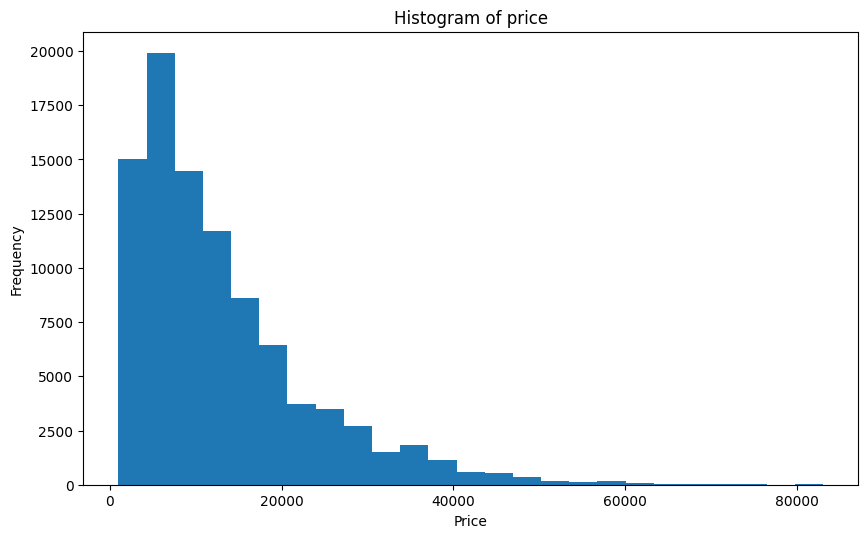

In [ ]:

plt.figure(num=None, figsize=(10, 6), dpi = 100)
#sns.set_style("whitegrid")
plt.hist(x = 'price', data = convert_df,bins=25)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of price')

Text(0.5, 1.0, 'Boxplot of Price')

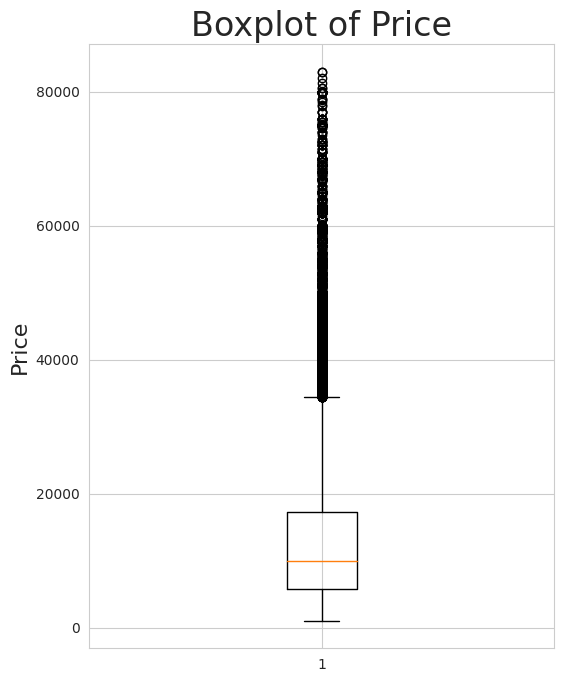

In [ ]:
plt.figure(num=None, figsize=(6, 8), dpi = 100)


sns.set_style("whitegrid")
plt.boxplot(x = 'price',data = result_df)
plt.ylabel('Price', size = 16)
plt.title('Boxplot of Price', size = 24)

Text(0.5, 1.0, 'Boxplot of Odometer')

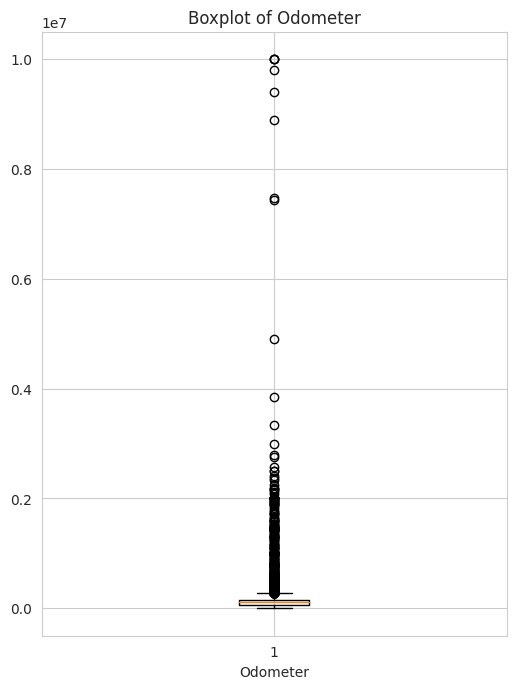

In [ ]:
plt.figure(num=None, figsize=(6, 8), dpi = 100)
sns.set_style("whitegrid")
plt.boxplot(x = 'odometer',data = convert_df)
plt.xlabel('Odometer')
plt.title('Boxplot of Odometer')

In [ ]:
year_filter = convert_df[convert_df['year'] > 1996]

Text(0.5, 1.0, 'Histogram of Year after 1996')

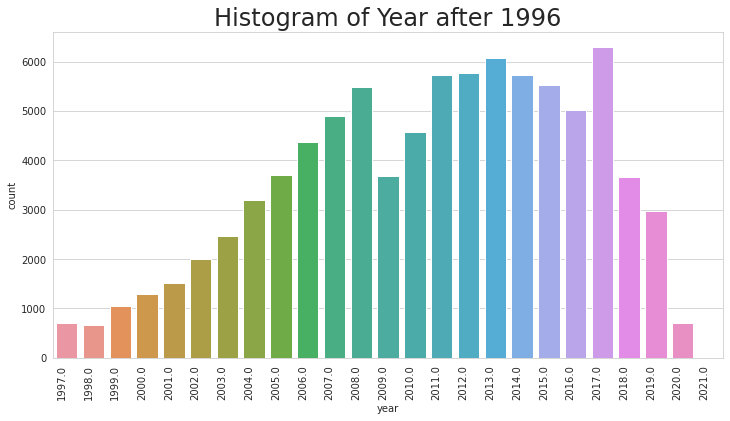

In [ ]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x='year',data=year_filter);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=10);
plt.title('Histogram of Year after 1996', fontsize=24)

Text(0.5, 1.0, 'Histogram of Year')

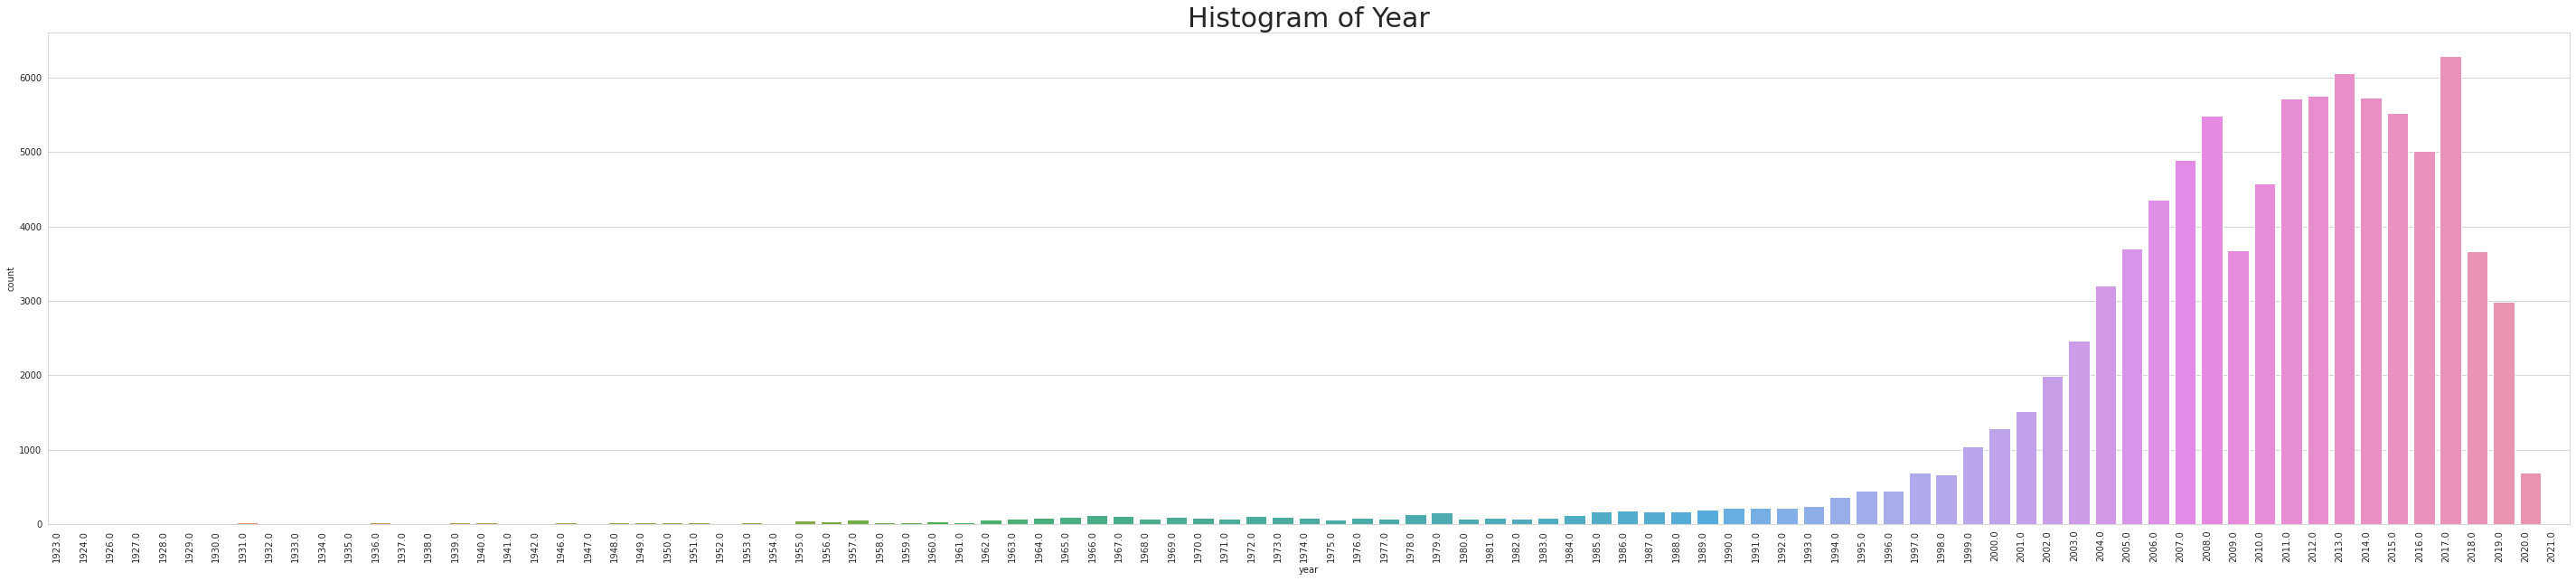

In [ ]:
plt.figure(figsize=(50,10))
ax = sns.countplot(x='year',data=convert_df);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=10);
plt.title('Histogram of Year', fontsize=30)

Text(0.5, 1.0, 'Boxplot of Year')

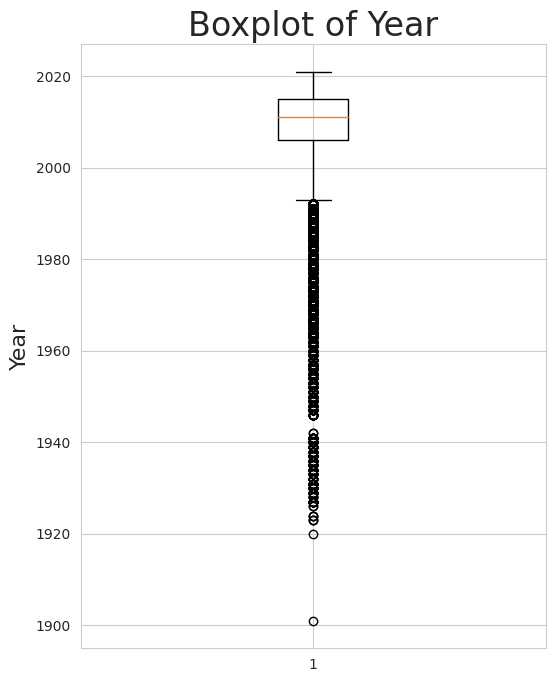

In [ ]:
plt.figure(num=None, figsize=(6, 8), dpi = 100)
sns.set_style("whitegrid")
plt.boxplot(x = 'year',data = result_df)
plt.ylabel('Year', size = 16)
plt.title('Boxplot of Year', size = 24)

Text(0.5, 1.0, 'No. of listings by Manufacturers')

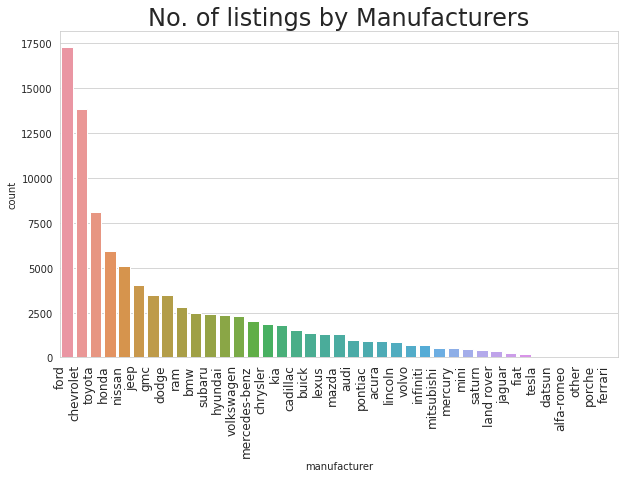

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='manufacturer',data=convert_df, order = convert_df['manufacturer'].value_counts().index);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=12);
plt.title("No. of listings by Manufacturers", fontsize=24)

Text(0.5, 1.0, 'No. of listings by Types')

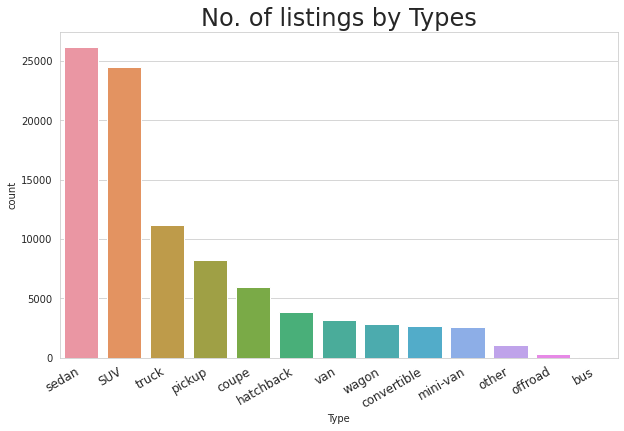

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='Type',data=convert_df, order = convert_df['Type'].value_counts().index);
ax.set_xticklabels(ax.get_xticklabels(),fontsize=12, rotation=30, ha="right");

plt.title("No. of listings by Types", fontsize=24)

Text(0.5, 1.0, 'No. of listings by Fuel')

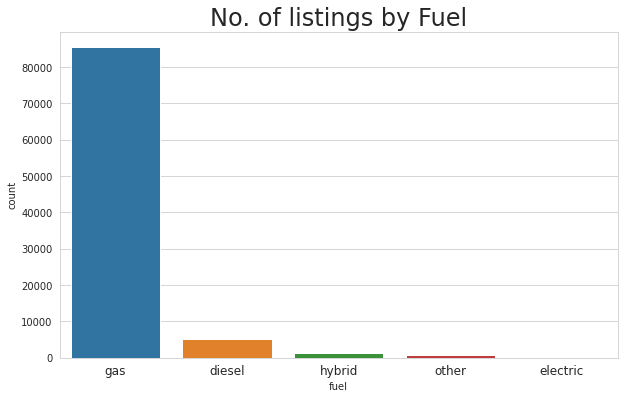

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='fuel',data=convert_df, order = convert_df['fuel'].value_counts().index);
ax.set_xticklabels(ax.get_xticklabels(),fontsize=12);
plt.title("No. of listings by Fuel", fontsize=24)

Text(0.5, 1.0, 'Cylinders vs no. of listings')

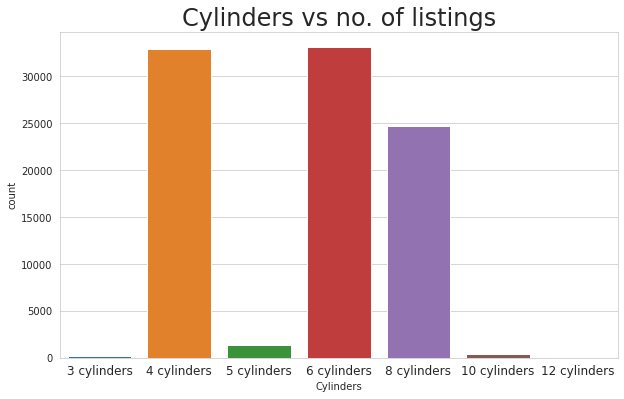

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='Cylinders',data=convert_df, order = ['3 cylinders','4 cylinders', '5 cylinders','6 cylinders','8 cylinders','10 cylinders','12 cylinders']);
ax.set_xticklabels(ax.get_xticklabels(),fontsize=12);
plt.title("Cylinders vs no. of listings", fontsize=24)

Text(0.5, 1.0, 'No. of listings by Condition')

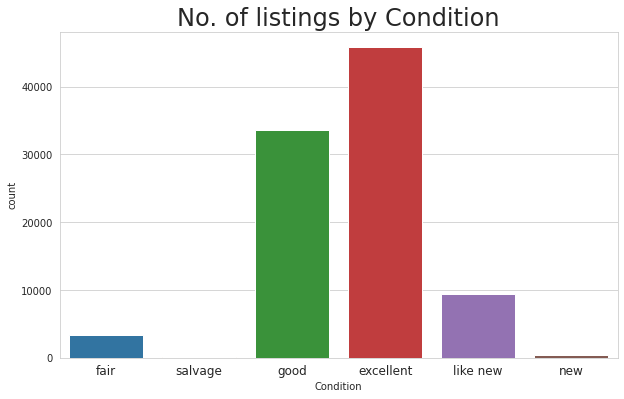

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='Condition',data=convert_df, order = ['fair','salvage', 'good', 'excellent', 'like new', 'new']);
ax.set_xticklabels(ax.get_xticklabels(),fontsize=12);
plt.title("No. of listings by Condition", fontsize=24)

**Two-Dimensional EDA**

Text(0.5, 1.0, 'Price vs Type')

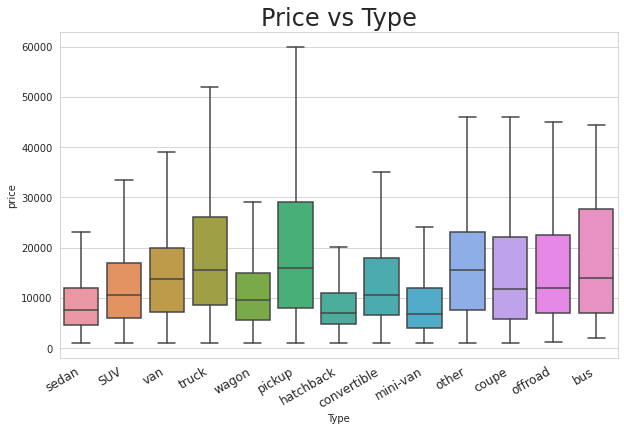

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(y='price', x='Type', data=convert_df, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=12, rotation=30, ha="right");
plt.title("Price vs Type", fontsize=24)

Text(0.5, 1.0, 'Price vs Fuel')

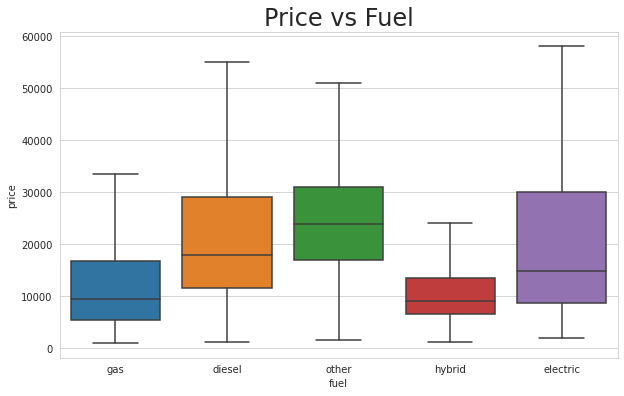

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(y='price', x='fuel', data=convert_df, showfliers=False)
plt.title("Price vs Fuel", fontsize=24)

Text(0.5, 1.0, 'Price vs Cylinders')

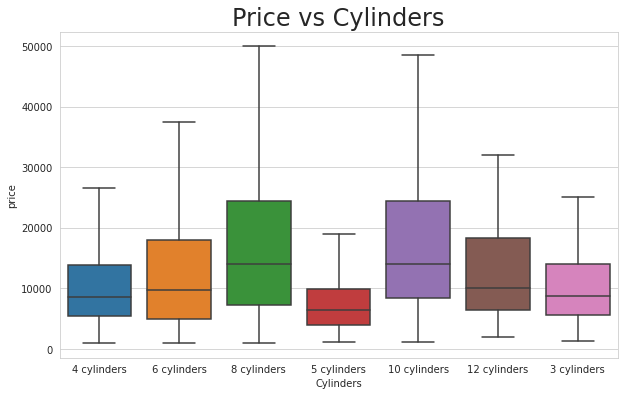

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(y='price', x='Cylinders', data=convert_df, showfliers=False)
plt.title("Price vs Cylinders", fontsize=24)

Text(0.5, 1.0, 'Price vs Condition')

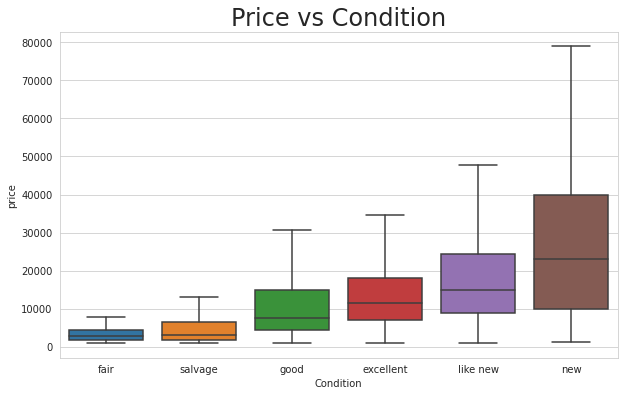

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(y='price', x='Condition', data=convert_df, showfliers=False, order = ['fair', 'salvage', 'good', 'excellent', 'like new', 'new'])
plt.title("Price vs Condition", fontsize=24)

Text(0.5, 1.0, 'Price vs Condition')

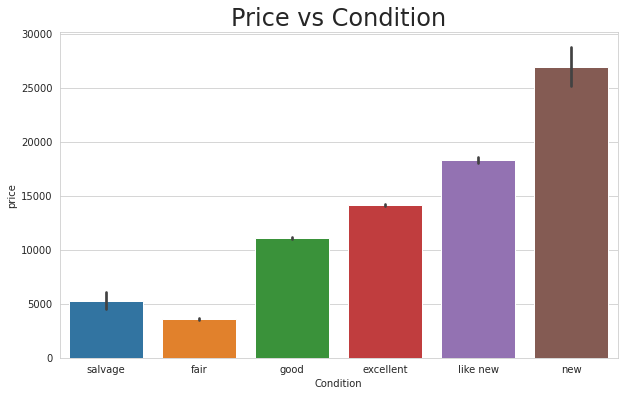

In [ ]:
# the barplot shows the central tendency
plt.figure(figsize=(10,6))
sns.barplot(x="Condition", y="price", data=convert_df, order = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new'])
plt.title("Price vs Condition", fontsize=24)

**Pairplot**

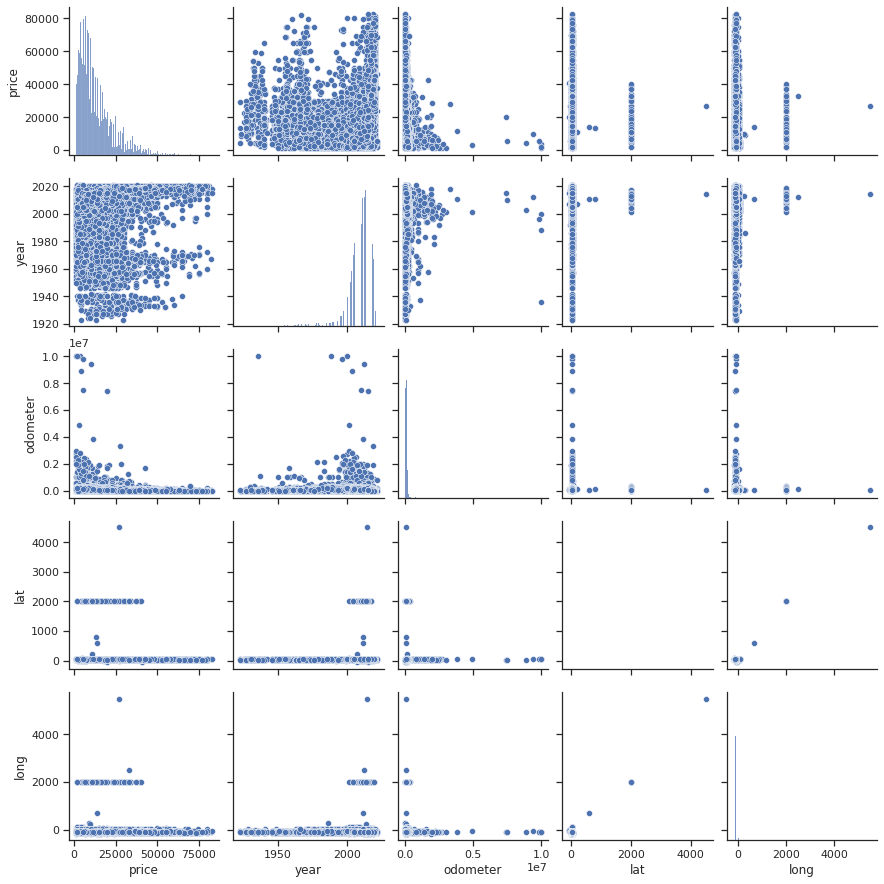

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(convert_df)

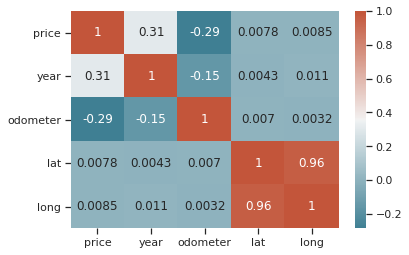

In [ ]:
corr = convert_df.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [ ]:
result_df['type'].unique()

array(['sedan', 'truck', 'SUV', 'other', 'mini-van', 'hatchback', 'coupe',
       'pickup', None, 'wagon', 'convertible', 'van', 'bus', 'offroad',
       ' S550'], dtype=object)

In [ ]:
#plt.figure(num=None, figsize=(15, 6), dpi = 100)
#plt.subplot(1,2,1)
#chart1 = sns.countplot(data = result_df,x='type',palette='Set1')
#plt.title("countplot of type")
#chart1.set_xticklabels(chart1.get_xticklabels(), rotation=45)

#plt.subplot(1,2,2)
#chart2 = sns.countplot(data = result_df,x='cylinders',palette='Set1')
#plt.title("countplot of cylinders")
#chart2.set_xticklabels(chart2.get_xticklabels(), rotation=45)

Text(0, 0.5, 'price')

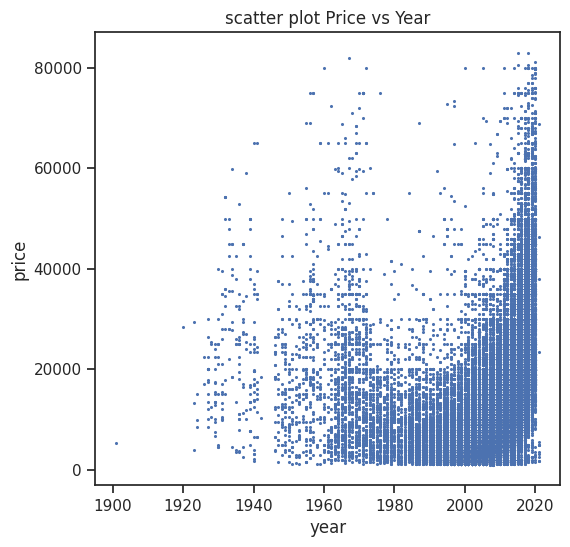

In [ ]:
plt.figure(num=None, figsize=(6, 6), dpi = 100)
plt.scatter(x = 'year', y = 'price', data = result_df,s = 1.5)
plt.title('scatter plot Price vs Year')
plt.xlabel('year')
plt.ylabel('price')


Text(0.5, 1.0, 'Year vs Condition')

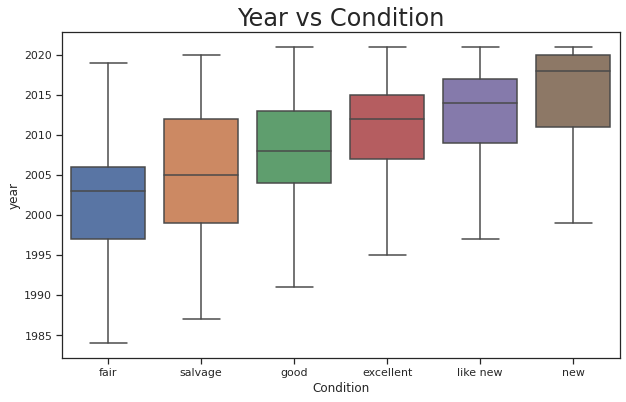

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(y='year', x='Condition', data=convert_df, showfliers=False, order = ['fair', 'salvage', 'good', 'excellent', 'like new', 'new'])
plt.title("Year vs Condition", fontsize=24)

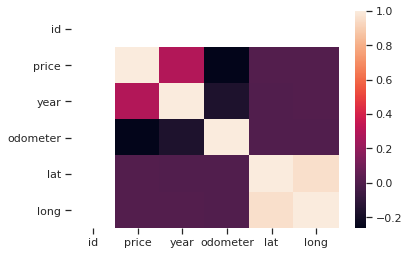

In [ ]:
#import pandas.rpy.common as com
import seaborn as sns
%matplotlib inline

# load the R package ISLR
#infert = com.importr("ISLR")
corr = result_df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)


In [ ]:
#from google.colab import drive
#drive.mount('drive')

#finally_convert.to_csv('/drive/My Drive/syr/finally_convert.csv')


# **Model**

# **Feature Encoding**

**condition column - change to numbers**

In [ ]:
# feature engineering for condition, ranking from salvage to new
from pyspark.ml.feature import StringIndexerModel
from pyspark.ml import Pipeline
string_indexer_condition = Pipeline(stages = [StringIndexerModel.from_labels(['fair', 'salvage', 'good', 'excellent', 'like new', 'new'], inputCol = 'Condition', outputCol = 'condition_index')])
string_indexer_fit = string_indexer_condition.fit(finally_convert)
new_filter_df = string_indexer_fit.transform(finally_convert)

In [ ]:
# drop the original column
new_filter_df = new_filter_df.drop('Condition')
# rename the new index column
new_filter_df = new_filter_df.withColumnRenamed('condition_index', 'condition')

In [ ]:
new_filter_df.show()

+-------+------+--------+--------------------+-------------+--------------------+------+------------+-----------+------------+-----+------+-----------+------------------+-------------------+--------------------+---------+
|  price|  year|odometer|              region| manufacturer|               model|  fuel|title_status|  Cylinders|Transmission|Drive|  Type|Paint_color|               lat|               long|              county|condition|
+-------+------+--------+--------------------+-------------+--------------------+------+------------+-----------+------------+-----+------+-----------+------------------+-------------------+--------------------+---------+
|14999.0|2016.0| 40629.0|    fargo / moorhead|        acura|                 ilx|   gas|       clean|4 cylinders|   automatic|  fwd| sedan|       grey| 46.91429901123047| -95.03450012207031|                null|      4.0|
| 4495.0|2007.0|172817.0|          bellingham|       saturn|                 vue|   gas|       clean|6 cylinders

**Cylinder column - keep numbers, drop text**

In [ ]:
string_indexer_cylinders = Pipeline(stages = [StringIndexerModel.from_labels(['3 cylinders', '4 cylinders', '5 cylinders', '6 cylinders', '8 cylinders', '10 cylinders', '12 cylinders'],inputCol="Cylinders", outputCol="cylinders_index")])
string_indexer_fit_c = string_indexer_cylinders.fit(new_filter_df)
new_filter_df = string_indexer_fit_c.transform(new_filter_df)
new_filter_df = new_filter_df.drop('Cylinders')
# rename the new index column
new_filter_df = new_filter_df.withColumnRenamed('cylinders_index', 'cylinders')

In [ ]:
# test_df['cylinders'] = new_filter_df['cylinders'].str.split(' ', 1).str
# new_filter_df.printSchema()
#import pyspark.sql.functions as fn
#split_col = fn.split(new_filter_df['Cylinders'], ' ')
#new_filter_df = new_filter_df.withColumn('newcylinders', split_col.getItem(0))

In [ ]:
# drop the original column
#new_filter_df = new_filter_df.drop('Cylinders')
# rename the new index column
#new_filter_df = new_filter_df.withColumnRenamed('newcylinders', 'cylinders')

**Title status**

In [ ]:
new_filter_df.select('title_status').distinct().rdd.map(lambda x: x[0]).collect()

['lien', 'missing', 'clean', 'salvage', 'rebuilt', 'parts only']

In [ ]:
string_indexer_title_status = Pipeline(stages = [StringIndexerModel.from_labels(['missing', 'lien', 'parts only', 'rebuilt', 'salvage', 'clean'], inputCol = 'title_status', outputCol = 'title_index')])
string_indexer_fit = string_indexer_title_status.fit(new_filter_df)
new_filter_df = string_indexer_fit.transform(new_filter_df)

In [ ]:
new_filter_df = new_filter_df.drop('title_status')
# rename the new index column
new_filter_df = new_filter_df.withColumnRenamed('title_index', 'title_status')

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCols=["fuel", "Transmission", "Type","Drive","Paint_color"],
                        outputCols=["fuel_index", "transmissionVec_index", "typeVec_index","Drive_index","Paint_color_index"]).fit(new_filter_df)

**One hot encoding**

One hot encoding for fuel, transimission and typeVec

In [ ]:
new_filter_df_encode = indexer.transform(new_filter_df)
new_filter_df_encode.show()

+-------+------+--------+--------------------+-------------+--------------------+------+------------+-----+------+-----------+------------------+-------------------+--------------------+---------+---------+------------+----------+-----------+-------------+---------------------+-----------------+
|  price|  year|odometer|              region| manufacturer|               model|  fuel|Transmission|Drive|  Type|Paint_color|               lat|               long|              county|condition|cylinders|title_status|fuel_index|Drive_index|typeVec_index|transmissionVec_index|Paint_color_index|
+-------+------+--------+--------------------+-------------+--------------------+------+------------+-----+------+-----------+------------------+-------------------+--------------------+---------+---------+------------+----------+-----------+-------------+---------------------+-----------------+
|14999.0|2016.0| 40629.0|    fargo / moorhead|        acura|                 ilx|   gas|   automatic|  fwd| s

In [ ]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCols=["fuel_index", "transmissionVec_index", "typeVec_index","Drive_index","Paint_color_index"],
                        outputCols=["fuelVec", "transmissionVec", "typeVec","driveVec","Paint_colorVec"])

encoderModel = encoder.fit(new_filter_df_encode)
new_filter_df = encoderModel.transform(new_filter_df_encode)

**Manufacturer**

In [ ]:
new_filter_df.select('manufacturer').distinct().rdd.map(lambda x: x[0]).collect()

['jaguar',
 'buick',
 'land rover',
 'mitsubishi',
 'pontiac',
 'lexus',
 'toyota',
 'chrysler',
 'tesla',
 'other',
 'lincoln',
 'audi',
 'datsun',
 'bmw',
 'jeep',
 'dodge',
 'hyundai',
 'ford',
 'alfa-romeo',
 'cadillac',
 'ram',
 'mazda',
 'ferrari',
 'kia',
 'mercedes-benz',
 'saturn',
 'chevrolet',
 'honda',
 'mini',
 'fiat',
 'volkswagen',
 'mercury',
 'acura',
 'gmc',
 'infiniti',
 'nissan',
 'subaru',
 'volvo',
 'porche']

In [ ]:
UK = ['jaguar', 'land rover']
USA = ['buick', 'pontiac', 'chrysler', 'tesla', 'lincoln', 'jeep', 'dodge', 'ford', 'cadillac', 'ram', 'saturn', 'chevrolet', 'mercury', 'gmc']
Japan = ['mitsubishi', 'lexus', 'toyota', 'datsun', 'mazda', 'honda', 'acura', 'infiniti', 'nissan', 'subaru']
Germany = ['audi', 'bmw', 'mercedes-benz', 'mini', 'volkswagen', 'porche']
SouthKorea = ['hyundai', 'kia']
Italy = ['alfa-remeo', 'ferrari', 'fiat']
Sweden = ['volvo']

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import *
def func_1(manufacturer):
  if manufacturer in UK:
    return 'UK'
  elif manufacturer in USA:
    return 'USA'
  elif manufacturer in Japan:
    return 'Japan'
  elif manufacturer in Germany:
    return 'Germany'
  elif manufacturer in SouthKorea:
    return 'SouthKorea'
  elif manufacturer in Italy:
    return 'Italy'
  else:
    return 'Sweden'

udf_country = udf(func_1, StringType())
# test_df = new_filter_df.withColumn('Country', udf(col('Country')))

In [ ]:
test_df = new_filter_df.withColumn('Country', udf_country(new_filter_df.manufacturer))

In [ ]:
test_df.show()

+-------+------+--------+--------------------+-------------+--------------------+------+------------+-----+------+-----------+------------------+-------------------+--------------------+---------+---------+------------+----------+-----------+-------------+---------------------+-----------------+--------------+-------------+-------------+--------------+---------------+----------+
|  price|  year|odometer|              region| manufacturer|               model|  fuel|Transmission|Drive|  Type|Paint_color|               lat|               long|              county|condition|cylinders|title_status|fuel_index|Drive_index|typeVec_index|transmissionVec_index|Paint_color_index|Paint_colorVec|     driveVec|      fuelVec|       typeVec|transmissionVec|   Country|
+-------+------+--------+--------------------+-------------+--------------------+------+------------+-----+------+-----------+------------------+-------------------+--------------------+---------+---------+------------+----------+------

**Standardization**

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

# Apply VecotorAssembler before standardization
year_va = VectorAssembler(inputCols=['year'], outputCol= 'year_va')
year_sd = StandardScaler(inputCol='year_va', outputCol='year_sd')
odometer_va = VectorAssembler(inputCols=['odometer'], outputCol= 'odometer_va')
odometer_sd = StandardScaler(inputCol='odometer_va', outputCol='odometer_sd')
condition_va = VectorAssembler(inputCols=['condition'], outputCol= 'condition_va')
condition_sd = StandardScaler(inputCol='condition_va', outputCol='condition_sd')
cylinders_va = VectorAssembler(inputCols=['cylinders'], outputCol= 'cylinders_va')
cylinders_sd = StandardScaler(inputCol='cylinders_va', outputCol='cylinders_sd')
title_status_va = VectorAssembler(inputCols=['title_status'], outputCol= 'title_status_va')
title_status_sd = StandardScaler(inputCol='title_status_va', outputCol='title_status_sd')

# Encapsulate all standardization
sd_pipe = Pipeline(stages = [year_va, year_sd, odometer_va, odometer_sd, condition_va, condition_sd, cylinders_va, cylinders_sd, title_status_va, title_status_sd])

# Transform the dataframe
test_df_sd = sd_pipe.fit(test_df).transform(test_df)

# Check the resutling dataframe
test_df_sd.show(5, truncate = False)

+-------+------+--------+----------------+------------+----------------------+------+------------+-----+-----+-----------+------------------+-------------------+-------------------------------------------------------------------------------------------------+---------+---------+------------+----------+-----------+-------------+---------------------+-----------------+--------------+-------------+-------------+--------------+---------------+-------+--------+--------------------+-----------+---------------------+------------+--------------------+------------+--------------------+---------------+--------------------+
|price  |year  |odometer|region          |manufacturer|model                 |fuel  |Transmission|Drive|Type |Paint_color|lat               |long               |county                                                                                           |condition|cylinders|title_status|fuel_index|Drive_index|typeVec_index|transmissionVec_index|Paint_color_index|Paint_colo

Transformation

In [ ]:
from pyspark.sql import functions as fn

# Apply log10 transforamtion to 'price'
test_df_log10 = test_df_sd.withColumn('price_log10', fn.log10(fn.col('price')))
test_df_log10.show(5)

+-------+------+--------+----------------+------------+--------------------+------+------------+-----+-----+-----------+------------------+-------------------+--------------------+---------+---------+------------+----------+-----------+-------------+---------------------+-----------------+--------------+-------------+-------------+--------------+---------------+-------+--------+--------------------+-----------+--------------------+------------+--------------------+------------+--------------------+---------------+--------------------+------------------+
|  price|  year|odometer|          region|manufacturer|               model|  fuel|Transmission|Drive| Type|Paint_color|               lat|               long|              county|condition|cylinders|title_status|fuel_index|Drive_index|typeVec_index|transmissionVec_index|Paint_color_index|Paint_colorVec|     driveVec|      fuelVec|       typeVec|transmissionVec|Country| year_va|             year_sd|odometer_va|         odometer_sd|condi

In [ ]:
visual_df = test_df.toPandas()

In [ ]:
country_list = ['Japan', 'Germany']
jp_ger_df = visual_df[visual_df.Country.isin(country_list)]
jp_ger_df = jp_ger_df[jp_ger_df['year'] > 2015]
jp_ger_df = jp_ger_df[jp_ger_df['year'] < 2021]

In [ ]:
#jp_ger_df.head(10)

Text(0.5, 1.0, 'Price vs Manufacturer: Japan and Germany')

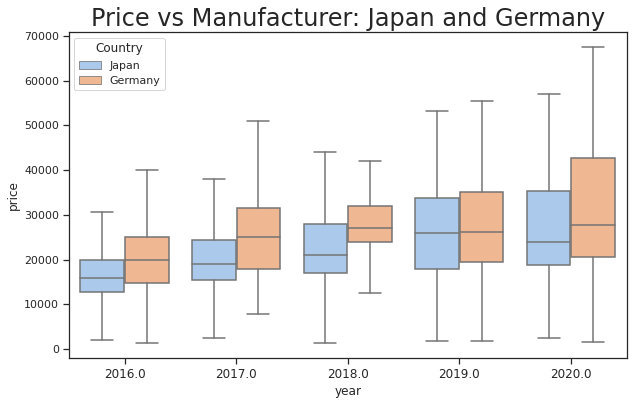

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(y='price', x='year', hue = 'Country', data=jp_ger_df, showfliers=False,  palette="pastel")
ax.set_xticklabels(ax.get_xticklabels(),fontsize=12);
plt.title("Price vs Manufacturer: Japan and Germany", fontsize=24)

## Split dataset

In [ ]:
# Split dataset into train, validation, test sets - set seed as 119
train, validation, test = test_df_log10.randomSplit([0.6, 0.3, 0.1], seed = 119)

# Check the number of rows in the three datasets
#[train.count(), validation.count(), test.count()]

# **Model 1 - Linear Regresssion**

## Split dataset

In [ ]:
# Split dataset into train, validation, test sets - set seed as 119
train, test = test_df_log10.randomSplit([0.7, 0.3], seed = 119)

# Check the number of rows in the three datasets
[train.count(), test.count()]

[65135, 27594]

## Case 1: No Transformation for 'price' and No Strandardization for Predictor Varibles

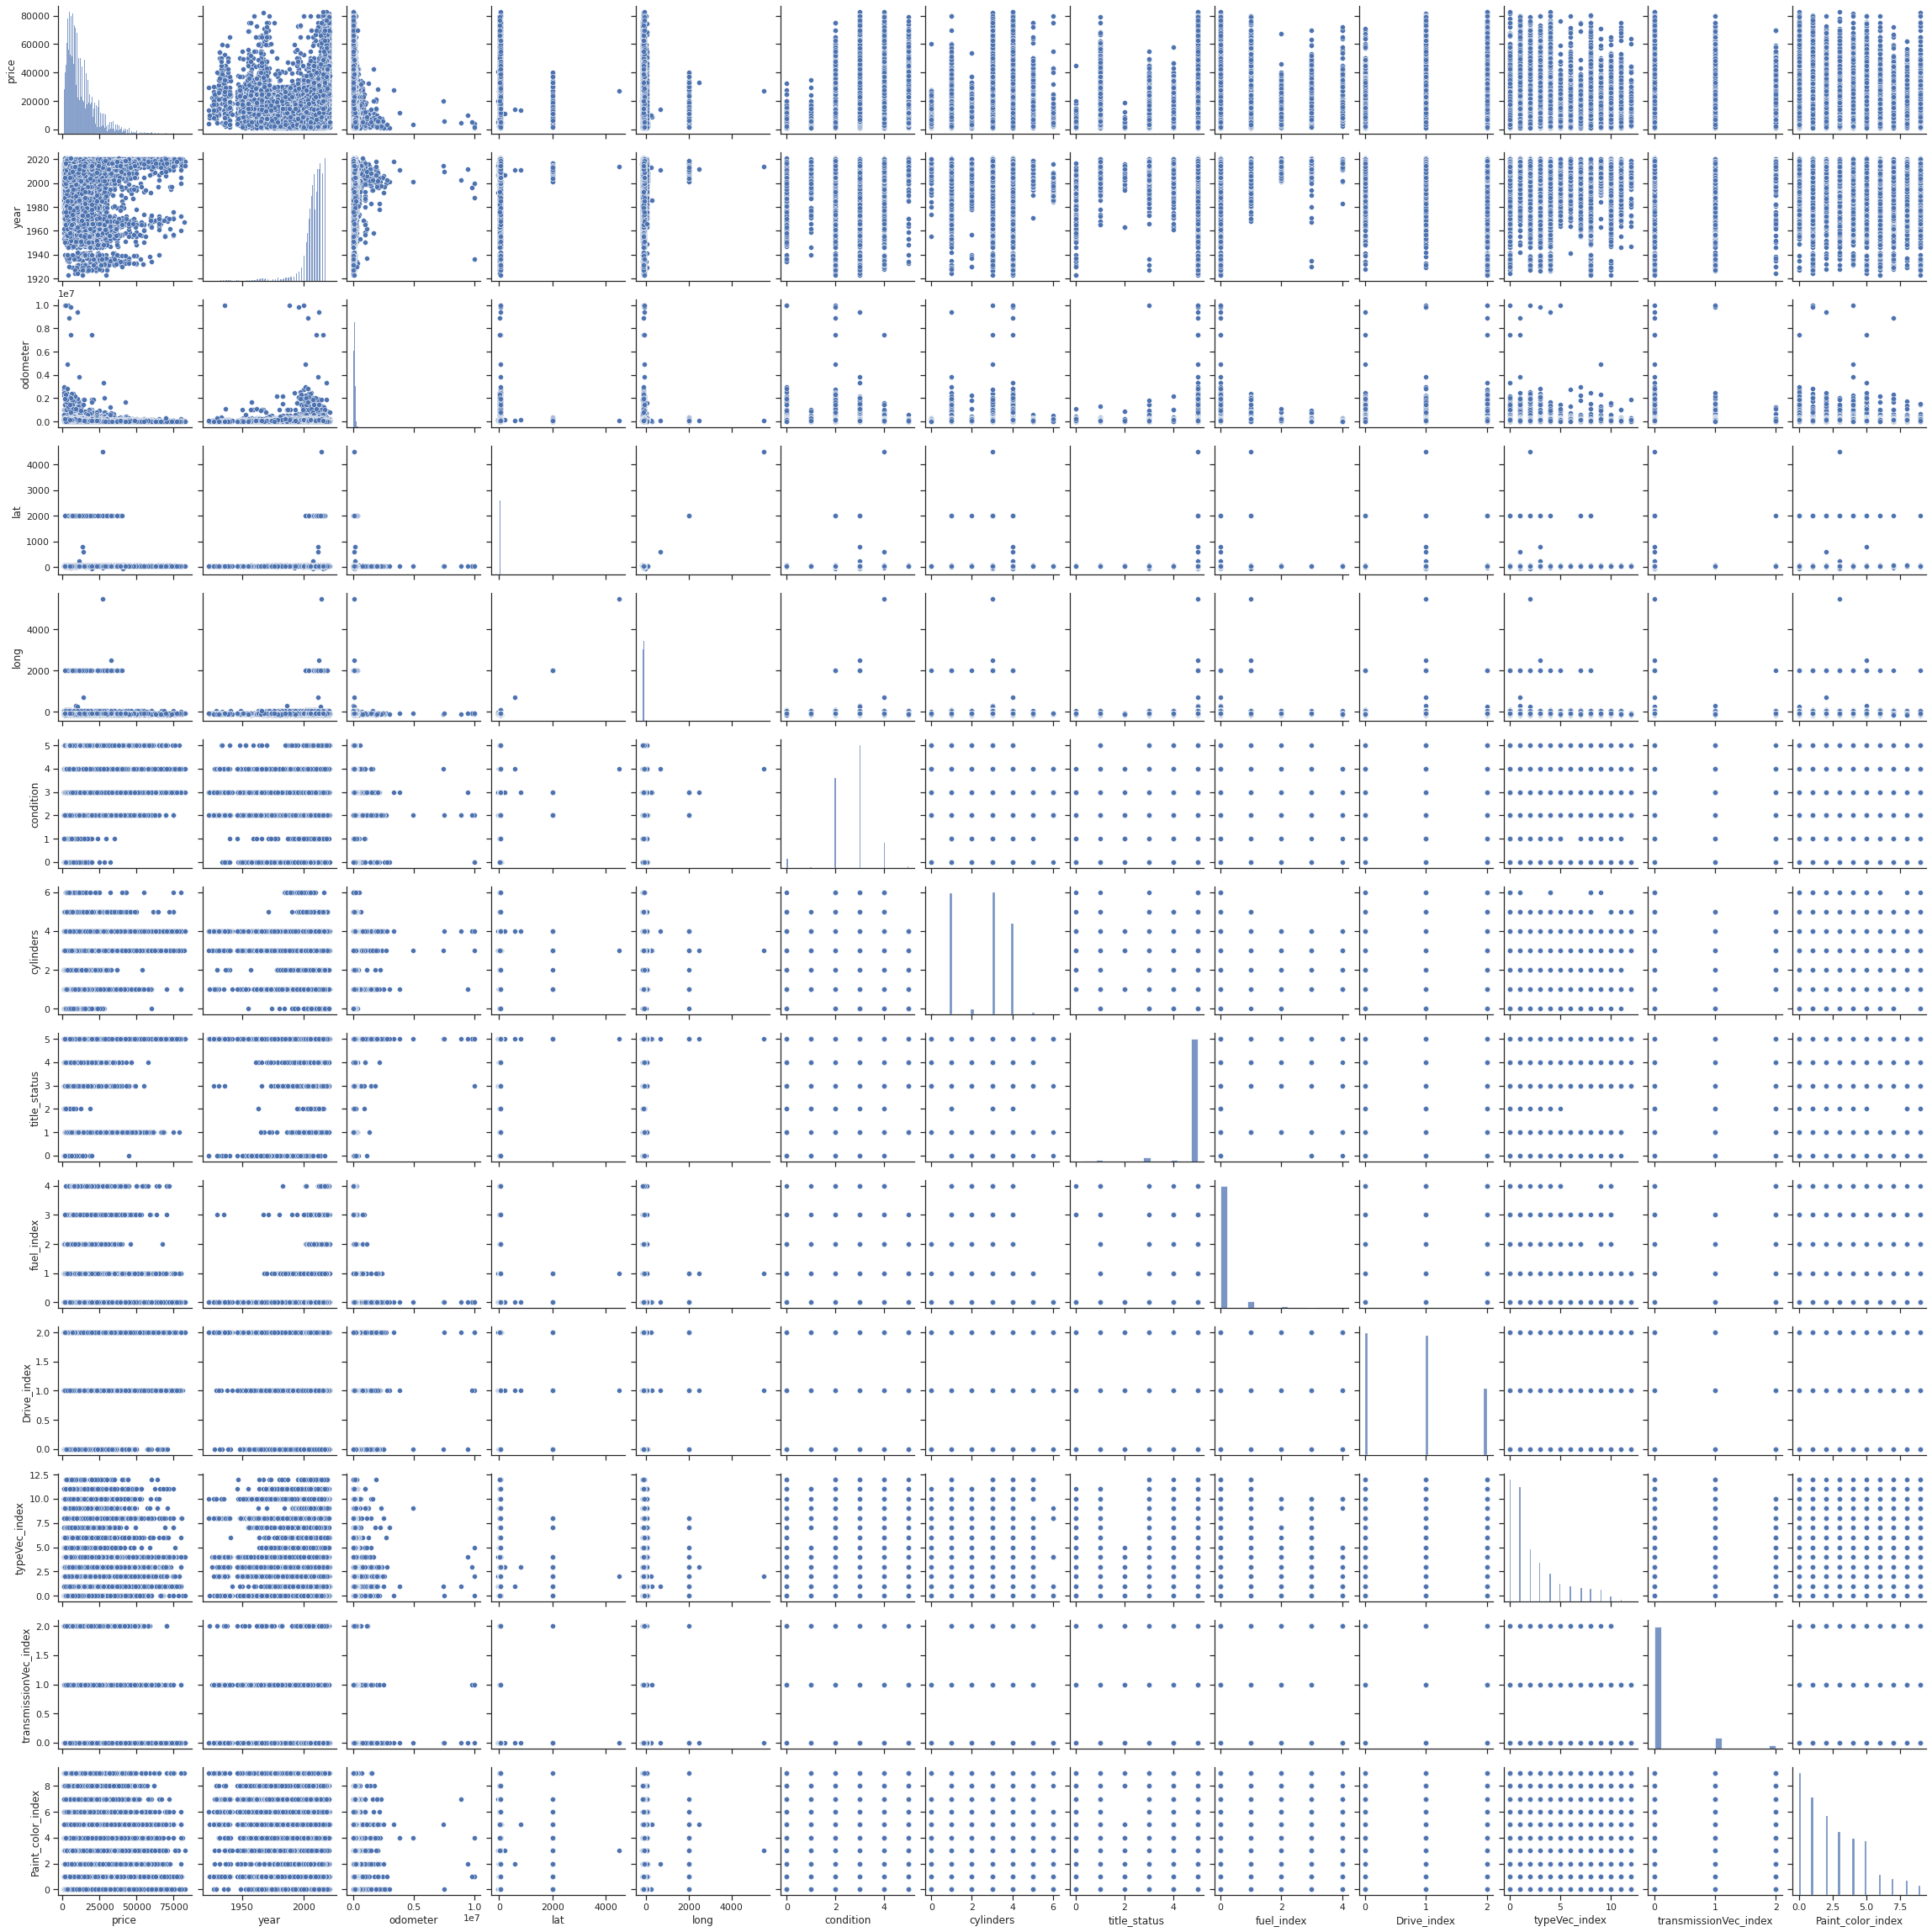

In [ ]:
# Generate the pairplot of test_df
import seaborn as sns
sns.pairplot(test_df.toPandas())

In [ ]:
from pyspark.ml.regression import LinearRegression

# Add the all variables into the initial linear regression model
assembler1 = VectorAssembler(inputCols=["year","condition",'odometer','cylinders','title_status','fuel_index','transmissionVec_index','typeVec_index','Drive_index'],outputCol="features")
df =  assembler1.transform(train)

#lr = LinearRegression(featuresCol = 'features', labelCol='price_log10', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr = LinearRegression(featuresCol = 'features', labelCol='price')
lr_model = lr.fit(df)
predictions = lr_model.transform(df) 

trainingSummary = lr_model.summary
print('No Transformation, No Standardization:')
print("Train RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("Train r^2: %f" % trainingSummary.r2)

# With all transformed perdictors added in the linear model, the RMSE drops significantly and r^2 increased from 0.408 to 0.438,
# thus the explanation power of the linear regression model sligtly increased

No Transformation, No Standardization:
Train RMSE: 8199.241031
Train r^2: 0.384195


In [ ]:
# Find the most important features (top 5) for this initial linear model
import numpy as np

train_pd = train.toPandas()
corr = train_pd.corr()
features = []
correlations = []
for idx, correlation in corr['price'].T.iteritems():
    if np.abs(correlation) >= .20 and idx != 'price' and idx != 'price_log10':
        features.append(idx)
        correlations.append(correlation)
corr_with_price = pd.DataFrame({'Correlations':correlations, 'Features': features})

Multicollinear_Features = []
Multicollinear_Corr = []
def check_multicollinearity(feature):
    for idx, correlation in corr[feature].T.iteritems():
        if correlation >= .80 and idx != feature:
            Multicollinear_Features.append([feature, idx])
            Multicollinear_Corr.append(correlation)
            
for feature in corr:
    check_multicollinearity(feature)
MC_df = pd.DataFrame({'Correlations':Multicollinear_Corr, 'Features': Multicollinear_Features})
print('Multicollinear Features_Train')
display(MC_df)
print('No Transformation, No Standardization:')
print('Correlations with Price')
display(corr_with_price)

Multicollinear Features_Train


,Correlations,Features
0,0.896762,"[price, price_log10]"
1,0.964250,"[lat, long]"
2,0.964250,"[long, lat]"
3,0.896762,"[price_log10, price]"


No Transformation, No Standardization:
Correlations with Price


,Correlations,Features
0,0.308585,year
1,-0.274413,odometer
2,0.284839,condition
3,0.257295,cylinders
4,0.250084,Drive_index


findfont: Font family ['Silom'] not found. Falling back to DejaVu Sans.


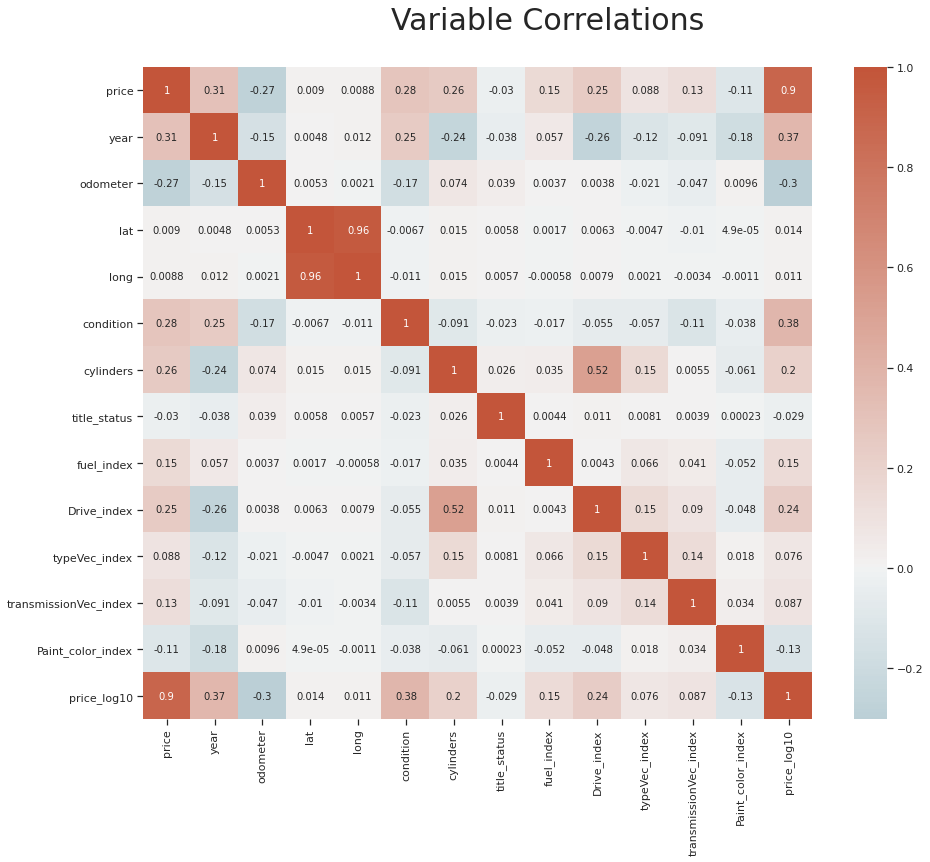

In [ ]:
import matplotlib.pyplot as plt
fig, ax=plt.subplots(figsize=(15,12))
fig.suptitle('Variable Correlations', fontsize=30, y=.95, fontname='Silom')
heatmap = sns.heatmap(corr, cmap=sns.diverging_palette(220, 20, as_cmap=True), center = 0, annot=True)

## Case 2: With Log Transformation for 'price' and No Strandardization for Predictor Varibles

In [ ]:
# Add the all variables into the initial linear regression model
assembler2 = VectorAssembler(inputCols=["year","condition",'odometer','cylinders','title_status','fuel_index','transmissionVec_index','typeVec_index','Drive_index'],outputCol="features")
df =  assembler2.transform(train)

#lr = LinearRegression(featuresCol = 'features', labelCol='price_log10', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr = LinearRegression(featuresCol = 'features', labelCol='price_log10')
lr_model = lr.fit(df)
predictions = lr_model.transform(df) 

trainingSummary = lr_model.summary
print('With Transformation, No Standardization:')
print("Train RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("Train r^2: %f" % trainingSummary.r2)

# With all transformed perdictors added in the linear model, the RMSE drops significantly and r^2 increased from 0.408 to 0.438,
# thus the explanation power of the linear regression model sligtly increased

With Transformation, No Standardization:
Train RMSE: 0.258478
Train r^2: 0.443895


In [ ]:
# Create a new dataframe to collect predictor names and corresponding coefficient (absolut) values
coefficients_df = pd.DataFrame({'feature': assembler2.getInputCols(), 
                                'coefficient value': lr_model.coefficients.tolist(), 
                                'coefficient absolute value': [np.abs(value) for value in lr_model.coefficients.tolist()]}).\
                                sort_values(by = 'coefficient absolute value', ascending = False).reset_index(drop = True)
display(coefficients_df)

,feature,coefficient value,coefficient absolute value
0,condition,1.273008e-01,1.273008e-01
1,Drive_index,1.074193e-01,1.074193e-01
2,transmissionVec_index,9.868895e-02,9.868895e-02
3,fuel_index,8.873945e-02,8.873945e-02
4,cylinders,5.705981e-02,5.705981e-02
5,year,1.363284e-02,1.363284e-02
6,typeVec_index,5.771154e-03,5.771154e-03
7,title_status,-5.266213e-03,5.266213e-03
8,odometer,-5.505106e-07,5.505106e-07


In [ ]:
# Find the most important features (top 5) for this linear model with 'price' log tranformed

corr = train_pd.corr()
features = []
correlations = []
for idx, correlation in corr['price_log10'].T.iteritems():
    if np.abs(correlation) >= .20 and idx != 'price_log10' and idx != 'price':
        features.append(idx)
        correlations.append(correlation)
corr_with_price_log10 = pd.DataFrame({'Correlations':correlations, 'Features': features})

Multicollinear_Features = []
Multicollinear_Corr = []
def check_multicollinearity(feature):
    for idx, correlation in corr[feature].T.iteritems():
        if correlation >= .80 and idx != feature:
            Multicollinear_Features.append([feature, idx])
            Multicollinear_Corr.append(correlation)
            
for feature in corr:
    check_multicollinearity(feature)
MC_df = pd.DataFrame({'Correlations':Multicollinear_Corr, 'Features': Multicollinear_Features})
print('Multicollinear Features')
display(MC_df)
print('With Transformation, No Standardization:')
print('Correlations with Price_log10')
display(corr_with_price_log10)

# 'year', 'odometer', 'condition', 'cylinders', 'Drive_index' are the five predictors that relatively more correlated to 'price_log10'

Multicollinear Features


,Correlations,Features
0,0.896762,"[price, price_log10]"
1,0.964250,"[lat, long]"
2,0.964250,"[long, lat]"
3,0.896762,"[price_log10, price]"


With Transformation, No Standardization:
Correlations with Price_log10


,Correlations,Features
0,0.365056,year
1,-0.301336,odometer
2,0.382216,condition
3,0.201922,cylinders
4,0.241040,Drive_index


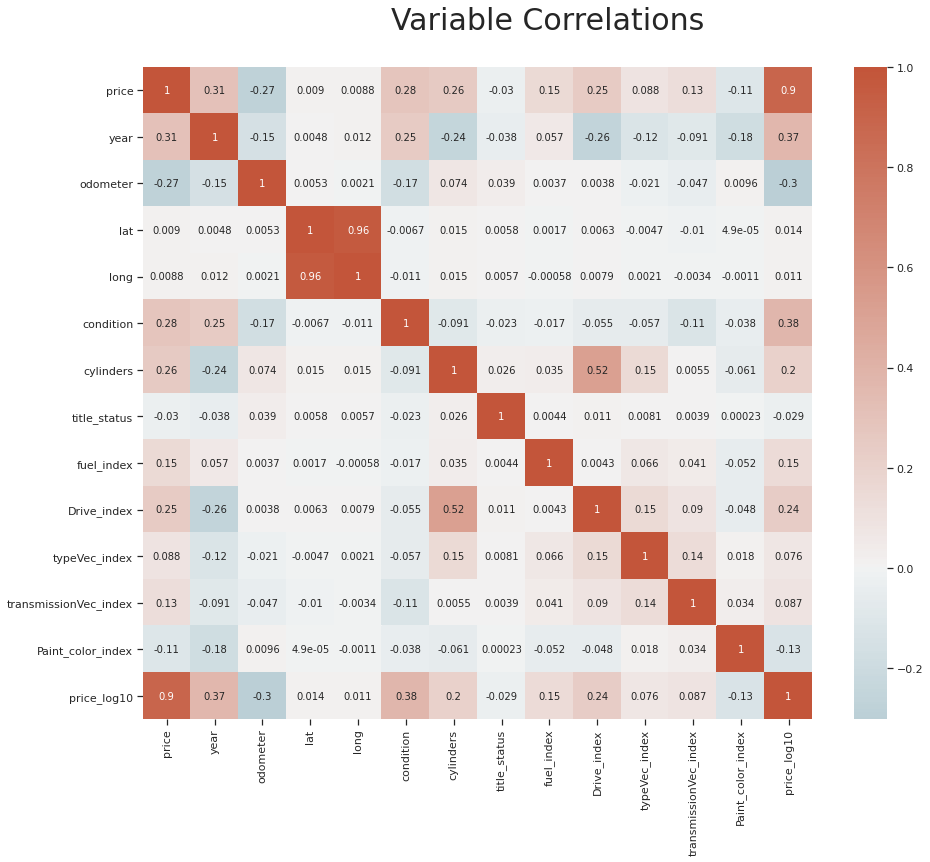

In [ ]:
# Generate the heat map of correlationship between variables
fig, ax=plt.subplots(figsize=(15,12))
fig.suptitle('Variable Correlations', fontsize=30, y=.95, fontname='Silom')
heatmap = sns.heatmap(corr, cmap = sns.diverging_palette(220, 20, as_cmap = True), center = 0, annot=True)

## Case 3: With Log Transformation for 'price' and Strandardization for Predictor Varibles

In [ ]:
train.show(5)

+------+------+--------+--------------------+------------+-----------+----+------------+-----+------+-----------+------------------+-------------------+------+---------+---------+------------+----------+-----------+-------------+---------------------+-----------------+--------------+-------------+-------------+--------------+---------------+-------+--------+--------------------+-----------+--------------------+------------+--------------------+------------+--------------------+---------------+-------------------+------------------+
| price|  year|odometer|              region|manufacturer|      model|fuel|Transmission|Drive|  Type|Paint_color|               lat|               long|county|condition|cylinders|title_status|fuel_index|Drive_index|typeVec_index|transmissionVec_index|Paint_color_index|Paint_colorVec|     driveVec|      fuelVec|       typeVec|transmissionVec|Country| year_va|             year_sd|odometer_va|         odometer_sd|condition_va|        condition_sd|cylinders_va| 

In [ ]:
# Add the all standardized variables into the linear regression model
assembler3 = VectorAssembler(inputCols=['year_sd','odometer_sd','condition_sd','cylinders_sd','title_status_sd','fuelVec', 'transmissionVec', 'typeVec','driveVec','Paint_colorVec'],outputCol="features")
df =  assembler3.transform(train)

lr = LinearRegression(featuresCol = 'features', labelCol='price_log10')
lr_model = lr.fit(df)
predictions = lr_model.transform(df) 

trainingSummary = lr_model.summary
print('With Transformation and Standardization:')
print("Train RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("Train r^2: %f" % trainingSummary.r2)

# With all transformed perdictors added in the linear model, the RMSE drops significantly and r^2 increased from 0.408 to 0.438,
# thus the explanation power of the linear regression model sligtly decreased

With Transformation and Standardization:
Train RMSE: 0.246648
Train r^2: 0.493634


In [ ]:
# Find the most important features (top 5) for this linear model with 'price' log tranformed and predictor variables standardized

corr = train_pd.corr()
features = []
correlations = []
for idx, correlation in corr['price_log10'].T.iteritems():
    if np.abs(correlation) >= .20 and idx != 'price_log10' and idx != 'price':
        features.append(idx)
        correlations.append(correlation)
corr_with_price_log10 = pd.DataFrame({'Correlations':correlations, 'Features': features})

Multicollinear_Features = []
Multicollinear_Corr = []
def check_multicollinearity(feature):
    for idx, correlation in corr[feature].T.iteritems():
        if correlation >= .80 and idx != feature:
            Multicollinear_Features.append([feature, idx])
            Multicollinear_Corr.append(correlation)
            
for feature in corr:
    check_multicollinearity(feature)
MC_df = pd.DataFrame({'Correlations':Multicollinear_Corr, 'Features': Multicollinear_Features})
print('Multicollinear Features')
display(MC_df)
print('With Transformation and Standardization:')
print('Correlations with Price_log10')
display(corr_with_price_log10)

# 'year', 'odometer', 'condition', 'cylinders', 'Drive_index' are the five predictors that relatively more correlated to 'price_log10'

Multicollinear Features


,Correlations,Features
0,0.896762,"[price, price_log10]"
1,0.964250,"[lat, long]"
2,0.964250,"[long, lat]"
3,0.896762,"[price_log10, price]"


With Transformation and Standardization:
Correlations with Price_log10


,Correlations,Features
0,0.365056,year
1,-0.301336,odometer
2,0.382216,condition
3,0.201922,cylinders
4,0.241040,Drive_index


## Case 1-3 Encapsulate: Fit Train Dataset, Transform Validation Dataset

In [ ]:
from pyspark.ml.regression import LinearRegression
# stages
assembler1 = VectorAssembler(inputCols=["year","condition",'odometer','cylinders','title_status','fuelVec', 'transmissionVec', 'typeVec','driveVec','Paint_colorVec'],outputCol="features")
assembler2 = VectorAssembler(inputCols=["year","condition",'odometer','cylinders','title_status','fuelVec', 'transmissionVec', 'typeVec','driveVec','Paint_colorVec'],outputCol="features")
assembler3 = VectorAssembler(inputCols=['year_sd','odometer_sd','condition_sd','cylinders_sd','title_status_sd','fuelVec', 'transmissionVec', 'typeVec','driveVec','Paint_colorVec'],outputCol="features")
lr1 = LinearRegression(featuresCol = 'features', labelCol='price')
lr2 = LinearRegression(featuresCol = 'features', labelCol='price_log10')

In [ ]:
#  pipeline
raw_pipe = Pipeline(stages=[assembler1,lr1]).fit(train)
prediction_raw = raw_pipe.transform(validation)
trainingSummary1 = raw_pipe.stages[-1].summary
# summary
print('No Transformation, No Standardization:')
print("R^2: %f" % trainingSummary1.r2)
print("RMSE: %f" % trainingSummary1.rootMeanSquaredError)
print("MAE: %f" % trainingSummary1.meanAbsoluteError)

No Transformation, No Standardization:
R^2: 0.440472
RMSE: 7815.610688
MAE: 5355.451087


In [ ]:
# pipeline
raw_pipe = Pipeline(stages=[assembler2,lr2]).fit(train)
prediction_raw = raw_pipe.transform(validation)
trainingSummary2 = raw_pipe.stages[-1].summary
# summary
print('Transformation, No Standardization:')
print("R^2: %f" % trainingSummary2.r2)
print("RMSE: %f" % trainingSummary2.rootMeanSquaredError)
print("MAE: %f" % trainingSummary2.meanAbsoluteError)

Transformation, No Standardization:
R^2: 0.493634
RMSE: 0.246648
MAE: 0.183302


In [ ]:
# pipeline
raw_pipe = Pipeline(stages=[assembler3,lr2]).fit(train)
prediction_raw = raw_pipe.transform(validation)
trainingSummary3 = raw_pipe.stages[-1].summary
# summary
print('Transformation, Standardization:')
print("R^2: %f" % trainingSummary3.r2)
print("RMSE: %f" % trainingSummary3.rootMeanSquaredError)
print("MAE: %f" % trainingSummary3.meanAbsoluteError)

Transformation, Standardization:
R^2: 0.493634
RMSE: 0.246648
MAE: 0.183302


## Case 4: Implement the Step-wise Optimal Order

### For loop

In [ ]:
print(train.columns)

['price', 'year', 'odometer', 'region', 'manufacturer', 'model', 'fuel', 'Transmission', 'Drive', 'Type', 'Paint_color', 'lat', 'long', 'county', 'condition', 'cylinders', 'title_status', 'fuel_index', 'Drive_index', 'typeVec_index', 'transmissionVec_index', 'Paint_color_index', 'Paint_colorVec', 'driveVec', 'fuelVec', 'typeVec', 'transmissionVec', 'Country', 'year_va', 'year_sd', 'odometer_va', 'odometer_sd', 'condition_va', 'condition_sd', 'cylinders_va', 'cylinders_sd', 'title_status_va', 'title_status_sd', 'price_log10']


In [ ]:
# find the fisrt 
from pyspark.ml.regression import LinearRegression
columns = ['year_sd','odometer_sd','condition_sd','cylinders_sd','title_status_sd','fuelVec', 'transmissionVec', 'typeVec','driveVec','Paint_colorVec']
res = []
time = 0
mse_res = 0
r2 = 0
for i in columns:
  assembler = VectorAssembler(inputCols=[i],outputCol="features")
  lr = LinearRegression(featuresCol = 'features', labelCol='price_log10')
  loop_pipe = Pipeline(stages=[assembler,lr]).fit(train)
  prediction_raw = loop_pipe.transform(validation)
  trainingSummary = loop_pipe.stages[-1].summary
  mse = trainingSummary.rootMeanSquaredError
  r2 = trainingSummary.r2
  if time == 0:
    mse_res = mse
    r2_res = r2
    time += 1
    res.append(i)
  elif mse < mse_res:
    mse_res = mse
    r2_res = r2
    res.append(i)
print("mse:",mse_res)
print("r2:",r2_res)
print("content",res)

mse: 0.32029570519349765
r2: 0.14608876765319456
content ['year_sd', 'condition_sd']


In [ ]:
def find_best_pred(x,y,z):
  # parameter
  res = 0
  res_feature = []
  u = 0
  o = []
  for i in y:
    o = x.copy()
    o.append(i)
    s1 = VectorAssembler(inputCols=o,outputCol="features")
    r1 = LinearRegression(featuresCol = 'features', labelCol=z)
    loop_pipe = Pipeline(stages=[s1,r1]).fit(train)
    # get mse value
    predictions = loop_pipe.transform(validation)
    trainingSummary = loop_pipe.stages[-1].summary
    mse = trainingSummary.rootMeanSquaredError
    r2 = trainingSummary.r2
    if u == 0:
      res = mse
      res_feature = o
      u += 1
    elif mse < res:
      res = mse
      res_feature = o
    o = []
    #print(res_feature)
  return res_feature

In [ ]:
def get_stepwise_pred_list(h,x,z):
  r_res = 0
  x1 = []
  y1 = []
  feature = []
  x1 = h
  for i in range(len(x)):
    y1 = [j for j in x if j not in x1]
    x1 = find_best_pred(x1,y1,z)
  return x1

In [ ]:
r1 = get_stepwise_pred_list(['year_sd'], ['odometer_sd','condition_sd','cylinders_sd','title_status_sd','fuelVec', 'transmissionVec', 'typeVec','driveVec','Paint_colorVec'] , 'price_log10')
print(r1)

['year_sd', 'typeVec', 'condition_sd', 'odometer_sd', 'driveVec', 'fuelVec', 'transmissionVec', 'Paint_colorVec', 'cylinders_sd', 'title_status_sd']


### data frame

In [ ]:
# creat the correlation dataframe
train_pd = train.toPandas()
corr = train_pd.corr()
features = []
correlations = []
for idx, correlation in corr['price'].T.iteritems():
    if idx != 'price' and idx != 'price_log10' and idx != 'lat' and idx != 'long'  :
        features.append(idx)
        correlations.append(np.abs(correlation))
corr_with_price = pd.DataFrame({'Correlations':correlations, 'Features': features})
corr_with_price = corr_with_price.sort_values(by='Correlations',ascending=False)
r2 = corr_with_price['Features'].tolist()
print(r2)

['year', 'condition', 'odometer', 'cylinders', 'Drive_index', 'fuel_index', 'transmissionVec_index', 'Paint_color_index', 'typeVec_index', 'title_status']


In [ ]:
feature_dataframe = pd.DataFrame(list(zip(r2, r1)),columns =['Corr_Features', 'Step_Features']) 
display(feature_dataframe)

,Corr_Features,Step_Features
0,year,year_sd
1,condition,typeVec
2,odometer,condition_sd
3,cylinders,odometer_sd
4,Drive_index,driveVec
5,fuel_index,fuelVec
6,transmissionVec_index,transmissionVec
7,Paint_color_index,Paint_colorVec
8,typeVec_index,cylinders_sd
9,title_status,title_status_sd


# **Model 2 - Random Forest**

In [ ]:
# build a pipeline for analysis
rf_va = VectorAssembler(inputCols = ['year', 'odometer', 'condition', 'cylinders', 'title_status', 'fuel_index', 'transmissionVec_index', 'typeVec_index', 'Drive_index', 'Paint_color_index'], outputCol = 'rf_va_features')

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics

In [ ]:
# create pipeline for random forest regressor
rf = RandomForestRegressor(featuresCol = 'rf_va_features', labelCol='price')
rf_pipeline = Pipeline(stages=[rf_va, rf]).fit(train)

In [ ]:
# get evaluations to evaluate random forest performance
metrics_validation = RegressionMetrics(rf_pipeline.transform(validation).select("prediction","price").rdd.map(lambda x: (float(x[0]), float(x[1]))))
print("Transforming Validation Data Set")
print("R-squared is : ", metrics_validation.r2) 
print("RMSE is : " , metrics_validation.rootMeanSquaredError)
print("MAE is :" , metrics_validation.meanAbsoluteError)
print("Explained variance is : " , metrics_validation.explainedVariance)

Transforming Validation Data Set
R-squared is :  0.7089005913051142
RMSE is :  5659.445333256144
MAE is : 3738.9171952155925
Explained variance is :  59985430.064733446


## GBT

In [ ]:
from pyspark.ml.regression import GBTRegressor

In [ ]:
# create pipeline for GBT model
gbt = GBTRegressor(featuresCol = 'rf_va_features', labelCol = 'price')
gbr_pipe = Pipeline(stages = [rf_va, gbt]).fit(train)

In [ ]:
# collect data points and evaluate using 4 evaluation metrics
metrics_validation_gbr = RegressionMetrics(gbr_pipe.transform(validation).select("prediction","price").rdd.map(lambda x: (float(x[0]), float(x[1]))))
print("Transforming Validation Data Set")
print("R-squared is : ", metrics_validation_gbr.r2) 
print("RMSE is : " , metrics_validation_gbr.rootMeanSquaredError)
print("MAE is :" , metrics_validation_gbr.meanAbsoluteError)
print("Explained variance is : " , metrics_validation_gbr.explainedVariance)

Transforming Validation Data Set
R-squared is :  0.7762211440877405
RMSE is :  4962.068236182344
MAE is : 3234.0514020111605
Explained variance is :  87573408.08374877


## Prediction - Car Price

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
# read in test set
url = 'https://raw.githubusercontent.com/IST-718-Fall-2020/project_code_and_report-group14/master/data_group14/test_price.csv'
df1 = pd.read_csv(url)

In [ ]:
# create Pyspark dataframe
test_sp = spark.createDataFrame(df1)

In [ ]:
test_sp.dtypes

[('price', 'bigint'),
 ('year', 'bigint'),
 ('condition', 'bigint'),
 ('odometer', 'bigint'),
 ('cylinders', 'bigint'),
 ('title_status', 'bigint'),
 ('fuel_index', 'bigint'),
 ('transmissionVec_index', 'bigint'),
 ('typeVec_index', 'bigint'),
 ('Drive_index', 'bigint'),
 ('Paint_color_index', 'bigint')]

In [ ]:
test_sp.show()

+-----+----+---------+--------+---------+------------+----------+---------------------+-------------+-----------+-----------------+
|price|year|condition|odometer|cylinders|title_status|fuel_index|transmissionVec_index|typeVec_index|Drive_index|Paint_color_index|
+-----+----+---------+--------+---------+------------+----------+---------------------+-------------+-----------+-----------------+
|15590|2017|        3|   27201|        4|           3|         0|                    0|            1|          0|                0|
|16990|2017|        3|   45406|        4|           3|         0|                    0|            1|          1|                4|
|31990|2016|        3|   21869|        6|           3|         0|                    0|            0|          1|                0|
|31990|2016|        3|   30615|        8|           3|         0|                    0|            8|          2|                4|
|21990|2015|        3|   66192|        4|           3|         0|           

In [ ]:
# fit our new testing data from online resources 
gbr_pipe.transform(test_sp).show()

+-----+----+---------+--------+---------+------------+----------+---------------------+-------------+-----------+-----------------+--------------------+------------------+
|price|year|condition|odometer|cylinders|title_status|fuel_index|transmissionVec_index|typeVec_index|Drive_index|Paint_color_index|      rf_va_features|        prediction|
+-----+----+---------+--------+---------+------------+----------+---------------------+-------------+-----------+-----------------+--------------------+------------------+
|15590|2017|        3|   27201|        4|           3|         0|                    0|            1|          0|                0|[2017.0,27201.0,3...|30143.945023437613|
|16990|2017|        3|   45406|        4|           3|         0|                    0|            1|          1|                4|[2017.0,45406.0,3...|26899.670053940285|
|31990|2016|        3|   21869|        6|           3|         0|                    0|            0|          1|                0|[2016.0,2

## Prediction - How long should the buyer keep the car




In [ ]:
def get_ten_year_prediction(year, condition, current_odometer, annual_mileage, cylinders, title_status, fuel_index, transmissionVec_index, typeVec_index, Drive_index, Paint_color_index):
  year_list = []
  odometer_list = []
  cylinders_list = []
  title_status_list = []
  fuel_index_list = []
  transmissionVec_list = []
  typeVec_list = []
  Drive_list = []
  Paint_color_list = []
  condition_list = []
  year_ind = []
  for i in range(10):
    year_list.append(year + i)
    odometer_list.append(current_odometer + i * annual_mileage)
    cylinders_list.append(cylinders)
    title_status_list.append(title_status)
    fuel_index_list.append(fuel_index)
    transmissionVec_list.append(transmissionVec_index)
    typeVec_list.append(typeVec_index)
    Drive_list.append(Drive_index)
    Paint_color_list.append(Paint_color_index)
    year_ind.append(i+1)
    if (i == 5):
      condition = condition - 1
    condition_list.append(condition)
  
  df = sqlContext.createDataFrame(zip(year_ind, year_list, condition_list, odometer_list, cylinders_list, title_status_list, fuel_index_list, transmissionVec_list, typeVec_list, Drive_list, Paint_color_list)
  , schema=['year_ind','year', 'condition', 'odometer', 'cylinders', 'title_status', 'fuel_index', 'transmissionVec_index', 'typeVec_index', 'Drive_index', 'Paint_color_index'])

  df_predict = gbr_pipe.transform(df)
  return df_predict


In [ ]:
get_ten_year_prediction(1999,2, 1000,100,4,4,4,4,4,4,4).show()

+--------+----+---------+--------+---------+------------+----------+---------------------+-------------+-----------+-----------------+--------------------+------------------+
|year_ind|year|condition|odometer|cylinders|title_status|fuel_index|transmissionVec_index|typeVec_index|Drive_index|Paint_color_index|      rf_va_features|        prediction|
+--------+----+---------+--------+---------+------------+----------+---------------------+-------------+-----------+-----------------+--------------------+------------------+
|       1|1999|        2|    1000|        4|           4|         4|                    4|            4|          4|                4|[1999.0,1000.0,2....|10372.047790245873|
|       2|2000|        2|    1100|        4|           4|         4|                    4|            4|          4|                4|[2000.0,1100.0,2....|10372.047790245873|
|       3|2001|        2|    1200|        4|           4|         4|                    4|            4|          4|         

In [ ]:
tenyr_df = get_ten_year_prediction(1999,2, 1000,10000,4,4,4,4,4,4,4).toPandas()

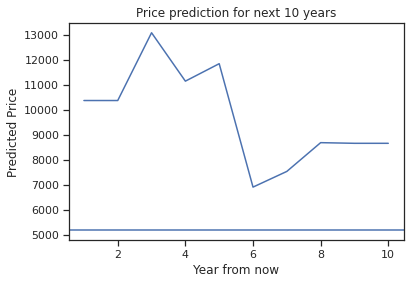

In [ ]:
plt.plot(tenyr_df['year_ind'], tenyr_df['prediction'])
plt.title('Price prediction for next 10 years')
plt.xlabel('Year from now')
plt.ylabel('Predicted Price')
plt.axhline(y=tenyr_df['prediction'][0] / 2)
plt.show()

In [ ]:
# get feature importances from GBT model
gbt_model = gbr_pipe.stages[1]
importances = gbt_model.featureImportances

In [ ]:
importances

SparseVector(10, {0: 0.3641, 1: 0.1742, 2: 0.0596, 3: 0.1505, 4: 0.0333, 5: 0.0392, 6: 0.0048, 7: 0.1009, 8: 0.0572, 9: 0.0163})

Text(0.5, 1.0, 'Feature Importances for Random Forest Model')

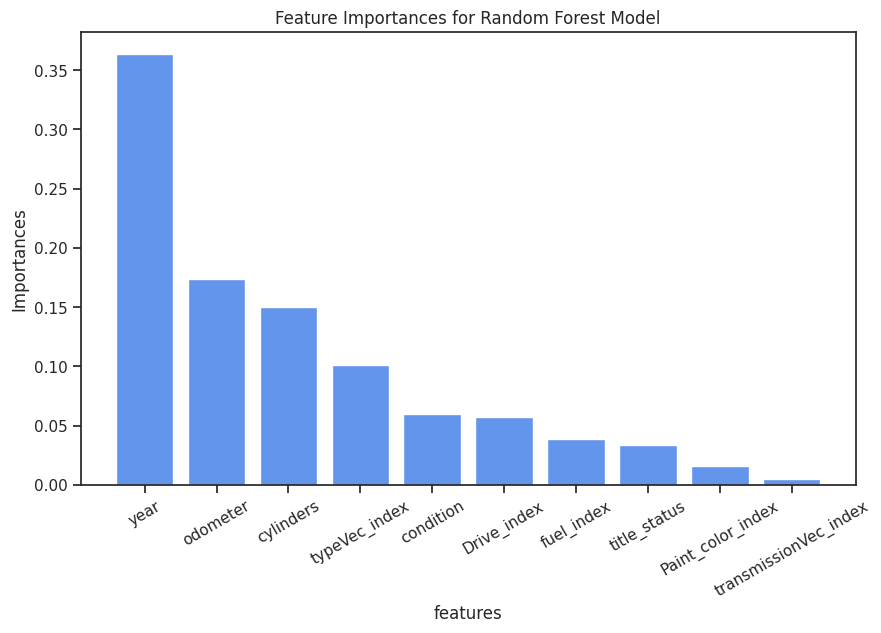

In [ ]:
# convert sparsevector to array preparing for plotting
import matplotlib.pyplot as plt
import_array = importances.toArray()
regre_list = ['year', 'odometer', 'condition', 'cylinders', 'title_status', 'fuel_index', 'transmissionVec_index', 'typeVec_index', 'Drive_index','Paint_color_index']
df = {'features': regre_list, 'Importances': import_array}
important_feature_df = pd.DataFrame(df)
important_feature_df = important_feature_df.sort_values('Importances', ascending = False)

plt.figure(num=None, figsize=(10, 6), dpi = 100)
plt.bar(x = 'features', height = 'Importances', data = important_feature_df, color = 'cornflowerblue')
plt.xticks(rotation = 30)
plt.ylabel('Importances')
plt.xlabel('features')
plt.title('Feature Importances for Random Forest Model')

In [ ]:
# list of feature importances
feature_importances_list = important_feature_df['features'].tolist()
feature_importances_list

['year',
 'odometer',
 'cylinders',
 'typeVec_index',
 'condition',
 'Drive_index',
 'fuel_index',
 'title_status',
 'Paint_color_index',
 'transmissionVec_index']

### **data frame**

In [ ]:
train_pd = train.toPandas()
corr = train_pd.corr()
features = []
correlations = []
for idx, correlation in corr['price_log10'].T.iteritems():
    if idx != 'price' and idx != 'price_log10' and idx != 'lat' and idx != 'long'  :
        features.append(idx)
        correlations.append(np.abs(correlation))
corr_with_price = pd.DataFrame({'Correlations':correlations, 'Features': features})
corr_with_price = corr_with_price.sort_values(by='Correlations',ascending=False)
r2 = corr_with_price['Features'].tolist()
print(r2)

['condition', 'year', 'odometer', 'Drive_index', 'cylinders', 'fuel_index', 'Paint_color_index', 'transmissionVec_index', 'typeVec_index', 'title_status']


In [ ]:
feature_dataframe = pd.DataFrame(list(zip(r2, r1,feature_importances_list)),columns =['Corr_Features', 'Step_Features','RF_Features']) 
display(feature_dataframe)

,Corr_Features,Step_Features,RF_Features
0,condition,year_sd,year
1,year,typeVec,odometer
2,odometer,condition_sd,cylinders
3,Drive_index,odometer_sd,typeVec_index
4,cylinders,driveVec,condition
5,fuel_index,fuelVec,Drive_index
6,Paint_color_index,transmissionVec,fuel_index
7,transmissionVec_index,Paint_colorVec,title_status
8,typeVec_index,cylinders_sd,Paint_color_index
9,title_status,title_status_sd,transmissionVec_index


## Cross-validation

**grid search**

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as fn
import numpy as np

enable_grid_search = False
if enable_grid_search:
  train, test = test_df_log10.randomSplit([0.7, 0.3], seed = 119)
  gbt = GBTRegressor(labelCol = 'price', featuresCol = 'rf_va_features')
  pipe2 = Pipeline(stages = [rf_va, gbt])

  paramGrid2 = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxBins, [40, 50]) \
    .addGrid(gbt.maxIter, [20, 30]) \
    .build()

  crossval2 = CrossValidator(estimator=pipe2,
                            estimatorParamMaps=paramGrid2,
                            evaluator=RegressionEvaluator(labelCol='price'),
                            numFolds=3)

  cvmodel2 = crossval2.fit(train)
  bestpipe2 = cvmodel2.bestModel
  bestModel2 = bestpipe2.stages[1]
  print('best maxdepth:', bestModel2.getOrDefault('maxDepth'))
  print('best maxIter:', bestModel2.getOrDefault('maxIter'))
  print('best maxbins:', bestModel2.getOrDefault('maxBins'))
  pass

**for inference**

In [ ]:
best_depth = 5
best_iter = 30
best_bins = 40

train, test = test_df_log10.randomSplit([0.7, 0.3], seed = 119)
# va = VectorAssembler().setInputCols(['carat', 'depth', 'table', 'x', 'y', 'z','cut', 'color', 'clarity']).setOutputCol('features')
# gbt_2 = GBTRegressor(featuresCol = 'features', labelCol = 'price', maxDepth = best_depth, maxIter = best_iter, maxBins = best_bins)
gbt_2 = GBTRegressor(featuresCol = 'features', labelCol = 'price_log10', maxBins = best_bins, maxDepth = best_depth, maxIter = best_iter)
best_pipe_2 = Pipeline(stages = [assembler3, gbt_2]).fit(train)

metrics_validation_gbt = RegressionMetrics(best_pipe_2.transform(test).select("prediction","price_log10").rdd.map(lambda x: (float(x[0]), float(x[1]))))
print("Transforming Validation Data Set")
print("R-squared is : ", metrics_validation_gbt.r2) 
print("RMSE is : " , metrics_validation_gbt.rootMeanSquaredError)
print("MAE is :" , metrics_validation_gbt.meanAbsoluteError)
print("Explained variance is : " , metrics_validation_gbt.explainedVariance)

Transforming Validation Data Set
R-squared is :  0.7758160268254373
RMSE is :  0.1639025129608395
MAE is : 0.11988990742198224
Explained variance is :  0.09595482161471368


**for prediction**

In [ ]:
best_depth = 5
best_iter = 30
best_bins = 40

train, test = test_df_log10.randomSplit([0.7, 0.3], seed = 119)
# va = VectorAssembler().setInputCols(['carat', 'depth', 'table', 'x', 'y', 'z','cut', 'color', 'clarity']).setOutputCol('features')
# gbt_2 = GBTRegressor(featuresCol = 'features', labelCol = 'price', maxDepth = best_depth, maxIter = best_iter, maxBins = best_bins)
gbt_2 = GBTRegressor(featuresCol = 'rf_va_features', labelCol = 'price', maxBins = best_bins, maxDepth = best_depth, maxIter = best_iter)
best_pipe_2 = Pipeline(stages = [rf_va, gbt_2]).fit(train)

metrics_validation_gbt = RegressionMetrics(best_pipe_2.transform(test).select("prediction","price").rdd.map(lambda x: (float(x[0]), float(x[1]))))
print("Transforming Validation Data Set")
print("R-squared is : ", metrics_validation_gbt.r2) 
print("RMSE is : " , metrics_validation_gbt.rootMeanSquaredError)
print("MAE is :" , metrics_validation_gbt.meanAbsoluteError)
print("Explained variance is : " , metrics_validation_gbt.explainedVariance)

Transforming Validation Data Set
R-squared is :  0.7822712917717716
RMSE is :  4884.24105989512
MAE is : 3168.2260823756997
Explained variance is :  88510831.22766852


### Test result

In [ ]:

test1 = VectorAssembler(inputCols=["year_sd"],outputCol="features")
test2 = VectorAssembler(inputCols=["year_sd","driveVec"],outputCol="features")
test3 = VectorAssembler(inputCols=['year_sd','driveVec','condition_sd'],outputCol="features")
lr2 = LinearRegression(featuresCol = 'features', labelCol='price_log10')

In [ ]:
test_pipe1 = Pipeline(stages=[test1,lr2]).fit(train)
prediction_raw = test_pipe1.transform(validation)
trainingSummary = test_pipe1.stages[-1].summary
print('year_sd')
print("R^2: %f" % trainingSummary.r2)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("MAE: %f" % trainingSummary.meanAbsoluteError)

year_sd
R^2: 0.133266
RMSE: 0.322692
MAE: 0.255020


In [ ]:
test_pipe2 = Pipeline(stages=[test2,lr2]).fit(train)
prediction_raw = test_pipe2.transform(validation)
trainingSummary = test_pipe2.stages[-1].summary
print('year_sd, driveVec')
print("R^2: %f" % trainingSummary.r2)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("MAE: %f" % trainingSummary.meanAbsoluteError)

year_sd, driveVec
R^2: 0.270068
RMSE: 0.296132
MAE: 0.226494


In [ ]:
test_pipe3 = Pipeline(stages=[test3,lr2]).fit(train)
prediction_raw = test_pipe3.transform(validation)
trainingSummary = test_pipe3.stages[-1].summary
print('year_sd, driveVec,condition_sd')
print("R^2: %f" % trainingSummary.r2)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("MAE: %f" % trainingSummary.meanAbsoluteError)

year_sd, driveVec,condition_sd
R^2: 0.360012
RMSE: 0.277288
MAE: 0.215195


In [ ]:
# Included not-existing column 'Paint_colorVec'
test4 = VectorAssembler(inputCols=['year_sd', 'driveVec', 'condition_sd', 'typeVec', 'odometer_sd', 'fuelVec', 'transmissionVec', 'Paint_colorVec', 'cylinders_sd', 'title_status_sd'],outputCol="features")
test_pipe4 = Pipeline(stages=[test4,lr2]).fit(train)
prediction_raw = test_pipe4.transform(validation)
trainingSummary = test_pipe4.stages[-1].summary
print("Implement Step-wise Optimal Order")
print('Final outcome:')
print("R^2: %f" % trainingSummary.r2)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("MAE: %f" % trainingSummary.meanAbsoluteError)

Implement Step-wise Optimal Order
Final outcome:
R^2: 0.493634
RMSE: 0.246648
MAE: 0.183302


In [ ]:
# Correct Step-wise Final Outcome should be
test4 = VectorAssembler(inputCols=['year_sd', 'driveVec', 'condition_sd', 'typeVec', 'odometer_sd', 'fuelVec', 'transmissionVec', 'Paint_colorVec', 'cylinders_sd', 'title_status_sd'],outputCol="features")
test_pipe4 = Pipeline(stages=[test4,lr2]).fit(train)
prediction_raw = test_pipe4.transform(validation)
trainingSummary4 = test_pipe4.stages[-1].summary
print("Implement Step-wise Optimal Order")
print('Final outcome:')
print("R^2: %f" % trainingSummary4.r2)
print("RMSE: %f" % trainingSummary4.rootMeanSquaredError)
print("MAE: %f" % trainingSummary4.meanAbsoluteError)

Implement Step-wise Optimal Order
Final outcome:
R^2: 0.493634
RMSE: 0.246648
MAE: 0.183302


In [ ]:
# Implement the feature importance order resulting from GBT
test5 = VectorAssembler(inputCols=['year_sd', 'odometer','cylinders', 'typeVec_index', 'condition', 'Drive_index', 'fuel_index', 'title_status', 'Paint_color_index','transmissionVec_index'],outputCol="features")
test_pipe5 = Pipeline(stages=[test5,lr2]).fit(train)
prediction_raw = test_pipe5.transform(validation)
trainingSummary5 = test_pipe5.stages[-1].summary
print("Implement GBT Feature Importance Order")
print('Final outcome:')
print("R^2: %f" % trainingSummary5.r2)
print("RMSE: %f" % trainingSummary5.rootMeanSquaredError)
print("MAE: %f" % trainingSummary5.meanAbsoluteError)

Implement GBT Feature Importance Order
Final outcome:
R^2: 0.444284
RMSE: 0.258387
MAE: 0.195364


In [ ]:
# Summarize the model performance of all five linear regression models
modelname_list = ['No Transformation, No Standardization', 'Transformation, No Standardization', 'Transformation, Standardization',
                  'Step-wise Optimal Order', 'GBT Feature Importance Order']
r2_list = [trainingSummary1.r2, trainingSummary2.r2, trainingSummary3.r2, trainingSummary4.r2, trainingSummary5.r2]
RMSE_list = [trainingSummary1.rootMeanSquaredError, trainingSummary2.rootMeanSquaredError, trainingSummary3.rootMeanSquaredError, trainingSummary4.rootMeanSquaredError, trainingSummary5.rootMeanSquaredError]
MAE_list = [trainingSummary1.meanAbsoluteError, trainingSummary2.meanAbsoluteError, trainingSummary3.meanAbsoluteError, trainingSummary4.meanAbsoluteError, trainingSummary5.meanAbsoluteError]

lr_summary_df = pd.DataFrame({'Model': modelname_list, 'R^2': r2_list, 'RMSE': RMSE_list, 'MAE': MAE_list})

print('Linear Regression Model Performance Summary:')
display(lr_summary_df)

Linear Regression Model Performance Summary:


,Model,R^2,RMSE,MAE
0,"No Transformation, No Standardization",0.440472,7815.610688,5355.451087
1,"Transformation, No Standardization",0.493634,0.246648,0.183302
2,"Transformation, Standardization",0.493634,0.246648,0.183302
3,Step-wise Optimal Order,0.493634,0.246648,0.183302
4,GBT Feature Importance Order,0.444284,0.258387,0.195364


#**Inference**

In [ ]:
# dummy variables
inference_df = test_df_log10.select('price_log10','year','condition_sd','cylinders_sd','title_status_sd','fuelVec', 'transmissionVec', 'typeVec','driveVec','Paint_colorVec','Country')

In [ ]:
# filter Germany AND Japan
inference_df = inference_df.filter((inference_df.Country == 'Japan') | (inference_df.Country == 'Germany'))
inference_df = inference_df.filter(inference_df.year >= 2015)
inference_df = inference_df.withColumn('Country_Japan_1',when(inference_df['Country'] == 'Japan',1).otherwise(0))

In [ ]:
# create interaction variable
inference_df = inference_df.withColumn('Interaction_year',(inference_df.Country_Japan_1)*(inference_df.year))

In [ ]:
inference_df.show()

+------------------+------+--------------------+--------------------+--------------------+-------------+---------------+--------------+-------------+--------------+-------+---------------+----------------+
|       price_log10|  year|        condition_sd|        cylinders_sd|     title_status_sd|      fuelVec|transmissionVec|       typeVec|     driveVec|Paint_colorVec|Country|Country_Japan_1|Interaction_year|
+------------------+------+--------------------+--------------------+--------------------+-------------+---------------+--------------+-------------+--------------+-------+---------------+----------------+
| 4.176062305125079|2016.0|[4.8563834930581775]|[0.8065615424294094]| [8.341578086954437]|(4,[0],[1.0])|  (2,[0],[1.0])|(12,[0],[1.0])|(2,[0],[1.0])| (9,[3],[1.0])|  Japan|              1|          2016.0|
| 4.218824238677402|2015.0| [3.642287619793633]|[0.8065615424294094]| [8.341578086954437]|(4,[0],[1.0])|  (2,[0],[1.0])|(12,[1],[1.0])|(2,[0],[1.0])| (9,[6],[1.0])|  Japan|    

In [ ]:
print(inference_df.columns)

['price_log10', 'year', 'condition_sd', 'cylinders_sd', 'title_status_sd', 'fuelVec', 'transmissionVec', 'typeVec', 'driveVec', 'Paint_colorVec', 'Country', 'Country_Japan_1', 'Interaction_year']


In [ ]:
# linear model
train, test = inference_df.randomSplit([0.7, 0.3], seed = 109)
assembler_i = VectorAssembler(inputCols=['year', 'condition_sd','cylinders_sd','title_status_sd','fuelVec', 'transmissionVec', 'typeVec','driveVec','Paint_colorVec', 'Country_Japan_1','Interaction_year'],outputCol="features")
lr_i = LinearRegression(featuresCol = 'features', labelCol='price_log10')
lr_model = Pipeline(stages=[assembler_i,lr_i]).fit(inference_df)
predictions = lr_model.transform(inference_df) 
coe = lr_model.stages[-1].coefficients

In [ ]:
# feature list will be linked to the coefficient
feature_list = []
for i in inference_df.columns:
  if i != 'price_log10' and i != 'Country':
    feature_list.append(i)
  else:
    continue

In [ ]:
# dataframe
lr_coefficient = pd.DataFrame(list(zip(feature_list, coe)),columns = ['feature', 'coefficient'])
display(lr_coefficient)

,feature,coefficient
0,year,0.058843
1,condition_sd,0.017105
2,cylinders_sd,0.094742
3,title_status_sd,0.013014
4,fuelVec,0.060512
5,transmissionVec,0.087287
6,typeVec,0.134614
7,driveVec,0.044714
8,Paint_colorVec,-0.071729
9,Country_Japan_1,-0.041696


*   Every additional year of car production is predicted to increase a Japan car selling price by 0.83 in LN\$ less than a Germany car
*   All esle equal, Japan cars are predicted to sell 0.08 in LN\$ less than Germany cars.



**inference 2**

In [ ]:
assembler_s = VectorAssembler(inputCols=['year_sd', 'driveVec', 'condition_sd', 'typeVec', 'odometer_sd', 'fuelVec', 'transmissionVec', 'Paint_colorVec', 'cylinders_sd', 'title_status_sd'],outputCol="features")
lr_s = LinearRegression(featuresCol = 'features', labelCol='price_log10')
lr_model = Pipeline(stages=[assembler_s,lr_s]).fit(test_df_log10)
predictions = lr_model.transform(test_df_log10) 
coe = lr_model.stages[-1].coefficients

In [ ]:
feature_list = ['year_sd', 'driveVec', 'condition_sd', 'typeVec', 'odometer_sd', 'fuelVec', 'transmissionVec', 'Paint_colorVec', 'cylinders_sd', 'title_status_sd']

In [ ]:
# data frame of the coefficient
lr_coefficient = pd.DataFrame(list(zip(feature_list, coe)),columns = ['feature', 'coefficient'])
display(lr_coefficient)

,feature,coefficient
0,year_sd,0.117570
1,driveVec,-0.147072
2,condition_sd,-0.006014
3,typeVec,0.104189
4,odometer_sd,-0.174301
5,fuelVec,-0.130721
6,transmissionVec,-0.028299
7,Paint_colorVec,-0.031090
8,cylinders_sd,-0.033333
9,title_status_sd,-0.175349
